In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import glob
import os
import json
from datetime import datetime, timedelta
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import folium
from folium.plugins import HeatMap, MarkerCluster

warnings.filterwarnings('ignore')

# Advanced plotting configuration
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

print("EV PERFORMANCE ANALYSIS")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print("Project: EV Industry Market Intelligence")
print("=" * 60)

EV PERFORMANCE ANALYSIS
Analysis Date: 2025-08-31 16:37
Project: EV Industry Market Intelligence


In [4]:
import os
import glob
import pandas as pd

# Navigate to project root if we're in notebooks directory
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

RAW_DATA_DIR = "data/raw"

def latest_file(pattern):
    """Return the most recent file matching a pattern"""
    files = glob.glob(os.path.join(RAW_DATA_DIR, pattern))
    if not files:
        raise FileNotFoundError(f"No files found for pattern: {pattern}")
    return max(files, key=os.path.getctime)

try:
    # Load latest datasets
    epa_file = latest_file("epa_vehicles_20250829.csv")
    stations_file = latest_file("charging_stations_*_20250829.csv")  # Wildcard for CA or other states
    sales_file = latest_file("ev_sales_data_20250829.csv")
    
    df_vehicles = pd.read_csv(epa_file)
    df_stations = pd.read_csv(stations_file)
    
    # Try to parse dates in sales file, handle if column doesn't exist
    try:
        df_sales = pd.read_csv(sales_file, parse_dates=["date"])
    except (KeyError, ValueError):
        df_sales = pd.read_csv(sales_file)
        print("Note: Could not parse 'date' column in sales data")
    
    print("Loaded datasets:")
    print(f"- Vehicles: {epa_file} ({df_vehicles.shape})")
    print(f"- Stations: {stations_file} ({df_stations.shape})")
    print(f"- Sales: {sales_file} ({df_sales.shape})")
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Available files in data/raw:")
    all_files = glob.glob(os.path.join(RAW_DATA_DIR, "*.csv"))
    for file in all_files:
        print(f"  - {os.path.basename(file)}")
        
except Exception as e:
    print(f"Error loading datasets: {e}")

Loaded datasets:
- Vehicles: data/raw/epa_vehicles_20250829.csv ((48, 17))
- Stations: data/raw/charging_stations_CA_20250829.csv ((19915, 30))
- Sales: data/raw/ev_sales_data_20250829.csv ((80, 12))


In [6]:
# Figure saving setup
import os
from datetime import datetime

# Create directory
os.makedirs('outputs/figures', exist_ok=True)

# Helper function for saving figures
def save_current_figure(plot_name):
    """Save the current matplotlib figure with timestamp"""
    timestamp = datetime.now().strftime("%Y%m%d")
    filename = f'outputs/figures/{plot_name}_{timestamp}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved: {filename}")

In [8]:
def load_ev_datasets():
    """Enhanced data loading with comprehensive validation"""
    
    # Navigate to project root
    if os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')
    
    print(f"Working Directory: {os.getcwd()}")
    
    # Find latest data files
    file_patterns = {
        'vehicles': 'data/raw/epa_vehicles_*.csv',
        'stations': 'data/raw/charging_stations_*.csv',
        'sales': 'data/raw/ev_sales_data_*.csv'
    }
    
    datasets = {}
    file_info = {}
    
    for name, pattern in file_patterns.items():
        files = sorted(glob.glob(pattern))
        if not files:
            print(f"No {name} files found matching {pattern}")
            continue
            
        latest_file = files[-1]
        file_info[name] = latest_file
        
        try:
            df = pd.read_csv(latest_file)
            if df.empty:
                print(f"{name}: Empty dataset")
                continue
            
            datasets[name] = df
            print(f"{name}: {len(df):,} rows × {len(df.columns)} columns")
            
        except Exception as e:
            print(f"{name}: Loading error - {e}")
    
    return datasets, file_info

# Load datasets
datasets, file_info = load_ev_datasets()
required_datasets = ['vehicles', 'stations', 'sales']

if not all(dataset in datasets for dataset in required_datasets):
    print("\nCritical datasets missing. Please run data collection script first.")
    print("Run: python src/data_collection.py")
else:
    vehicles_df = datasets['vehicles'].copy()
    stations_df = datasets['stations'].copy()
    sales_df = datasets['sales'].copy()
    print(f"\nAll datasets loaded successfully!")


Working Directory: /Users/evanfu/Documents/Personal Projects/EV Performance Analysis/ev-performance-analysis
vehicles: 48 rows × 17 columns
stations: 19,915 rows × 30 columns
sales: 80 rows × 12 columns

All datasets loaded successfully!



EV EFFICIENCY ANALYSIS
Saved: outputs/figures/ev_efficiency_20250831.png


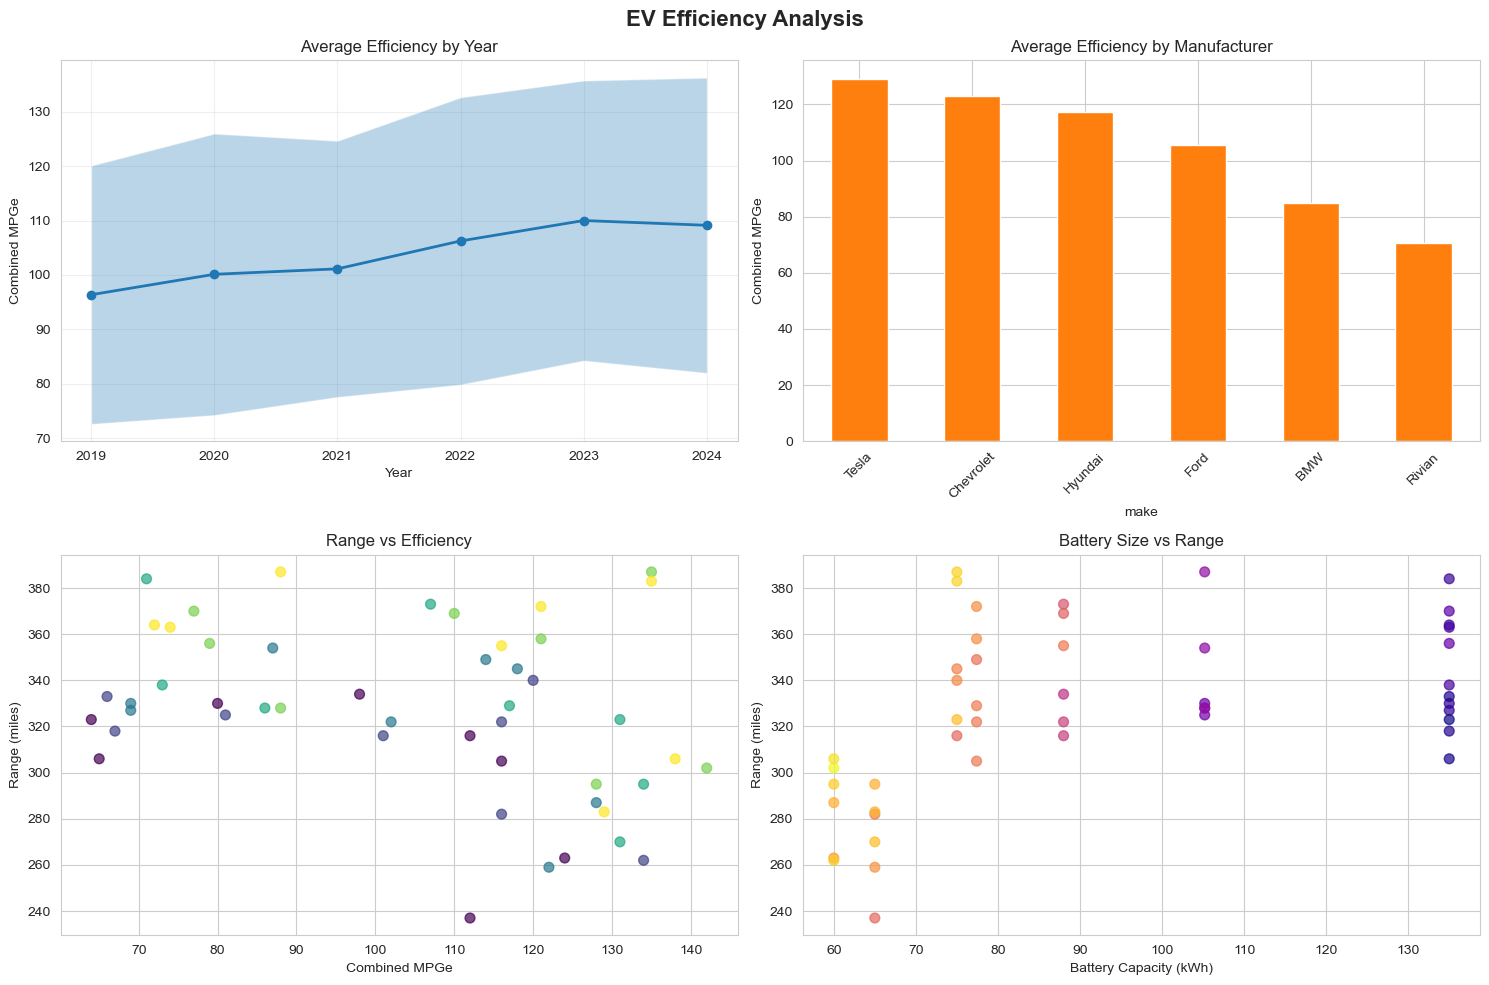


STATISTICAL INSIGHTS:
Average efficiency improvement per year: 2.1 MPGe
Saved: outputs/figures/ev_performance_correlation_20250831.png


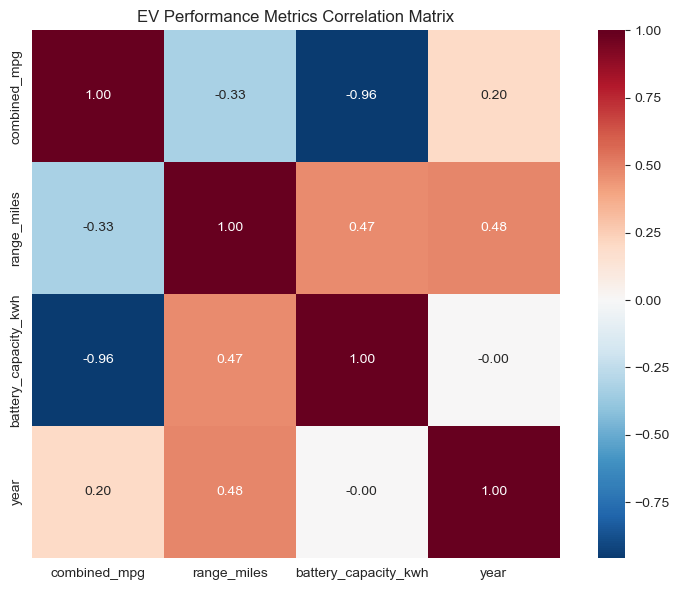


Strongest positive correlation: 1.00
Strongest negative correlation: -0.96


In [10]:
def analyze_ev_efficiency():
    """Advanced analysis of EV efficiency trends and patterns"""
    
    print("\nEV EFFICIENCY ANALYSIS")
    print("=" * 50)
    
    # 1. Efficiency trends over time
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('EV Efficiency Analysis', fontsize=16, fontweight='bold')
    
    # Efficiency by year
    yearly_efficiency = vehicles_df.groupby('year')['combined_mpg'].agg(['mean', 'std'])
    axes[0,0].plot(yearly_efficiency.index, yearly_efficiency['mean'], marker='o', linewidth=2)
    axes[0,0].fill_between(yearly_efficiency.index, 
                          yearly_efficiency['mean'] - yearly_efficiency['std'],
                          yearly_efficiency['mean'] + yearly_efficiency['std'], 
                          alpha=0.3)
    axes[0,0].set_title('Average Efficiency by Year')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Combined MPGe')
    axes[0,0].grid(True, alpha=0.3)
    
    # Efficiency by manufacturer
    make_efficiency = vehicles_df.groupby('make')['combined_mpg'].mean().sort_values(ascending=False)
    make_efficiency.plot(kind='bar', ax=axes[0,1], color=color_palette[1])
    axes[0,1].set_title('Average Efficiency by Manufacturer')
    axes[0,1].set_ylabel('Combined MPGe')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Range vs Efficiency scatter
    axes[1,0].scatter(vehicles_df['combined_mpg'], vehicles_df['range_miles'], 
                     c=vehicles_df['year'], cmap='viridis', alpha=0.7, s=50)
    axes[1,0].set_xlabel('Combined MPGe')
    axes[1,0].set_ylabel('Range (miles)')
    axes[1,0].set_title('Range vs Efficiency')
    
    # Battery capacity vs Range
    if 'battery_capacity_kwh' in vehicles_df.columns:
        axes[1,1].scatter(vehicles_df['battery_capacity_kwh'], vehicles_df['range_miles'],
                         c=vehicles_df['combined_mpg'], cmap='plasma', alpha=0.7, s=50)
        axes[1,1].set_xlabel('Battery Capacity (kWh)')
        axes[1,1].set_ylabel('Range (miles)')
        axes[1,1].set_title('Battery Size vs Range')
    
    plt.tight_layout()
    save_current_figure("ev_efficiency")
    plt.show()
    
    # Statistical analysis
    print("\nSTATISTICAL INSIGHTS:")
    print(f"Average efficiency improvement per year: {(yearly_efficiency['mean'].iloc[-1] - yearly_efficiency['mean'].iloc[0]) / len(yearly_efficiency):.1f} MPGe")
    
    # Correlation analysis
    numeric_cols = ['combined_mpg', 'range_miles', 'battery_capacity_kwh', 'year']
    available_cols = [col for col in numeric_cols if col in vehicles_df.columns]
    
    if len(available_cols) > 2:
        corr_matrix = vehicles_df[available_cols].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                   square=True, fmt='.2f')
        plt.title('EV Performance Metrics Correlation Matrix')
        plt.tight_layout()
        save_current_figure("ev_performance_correlation")
        plt.show()
        
        print(f"\nStrongest positive correlation: {corr_matrix.unstack().sort_values(ascending=False).iloc[1]:.2f}")
        print(f"Strongest negative correlation: {corr_matrix.unstack().sort_values().iloc[0]:.2f}")

if 'vehicles_df' in globals():
    analyze_ev_efficiency()


CHARGING INFRASTRUCTURE ANALYSIS
Saved: outputs/figures/ev_charging_infrastructure_20250831.png


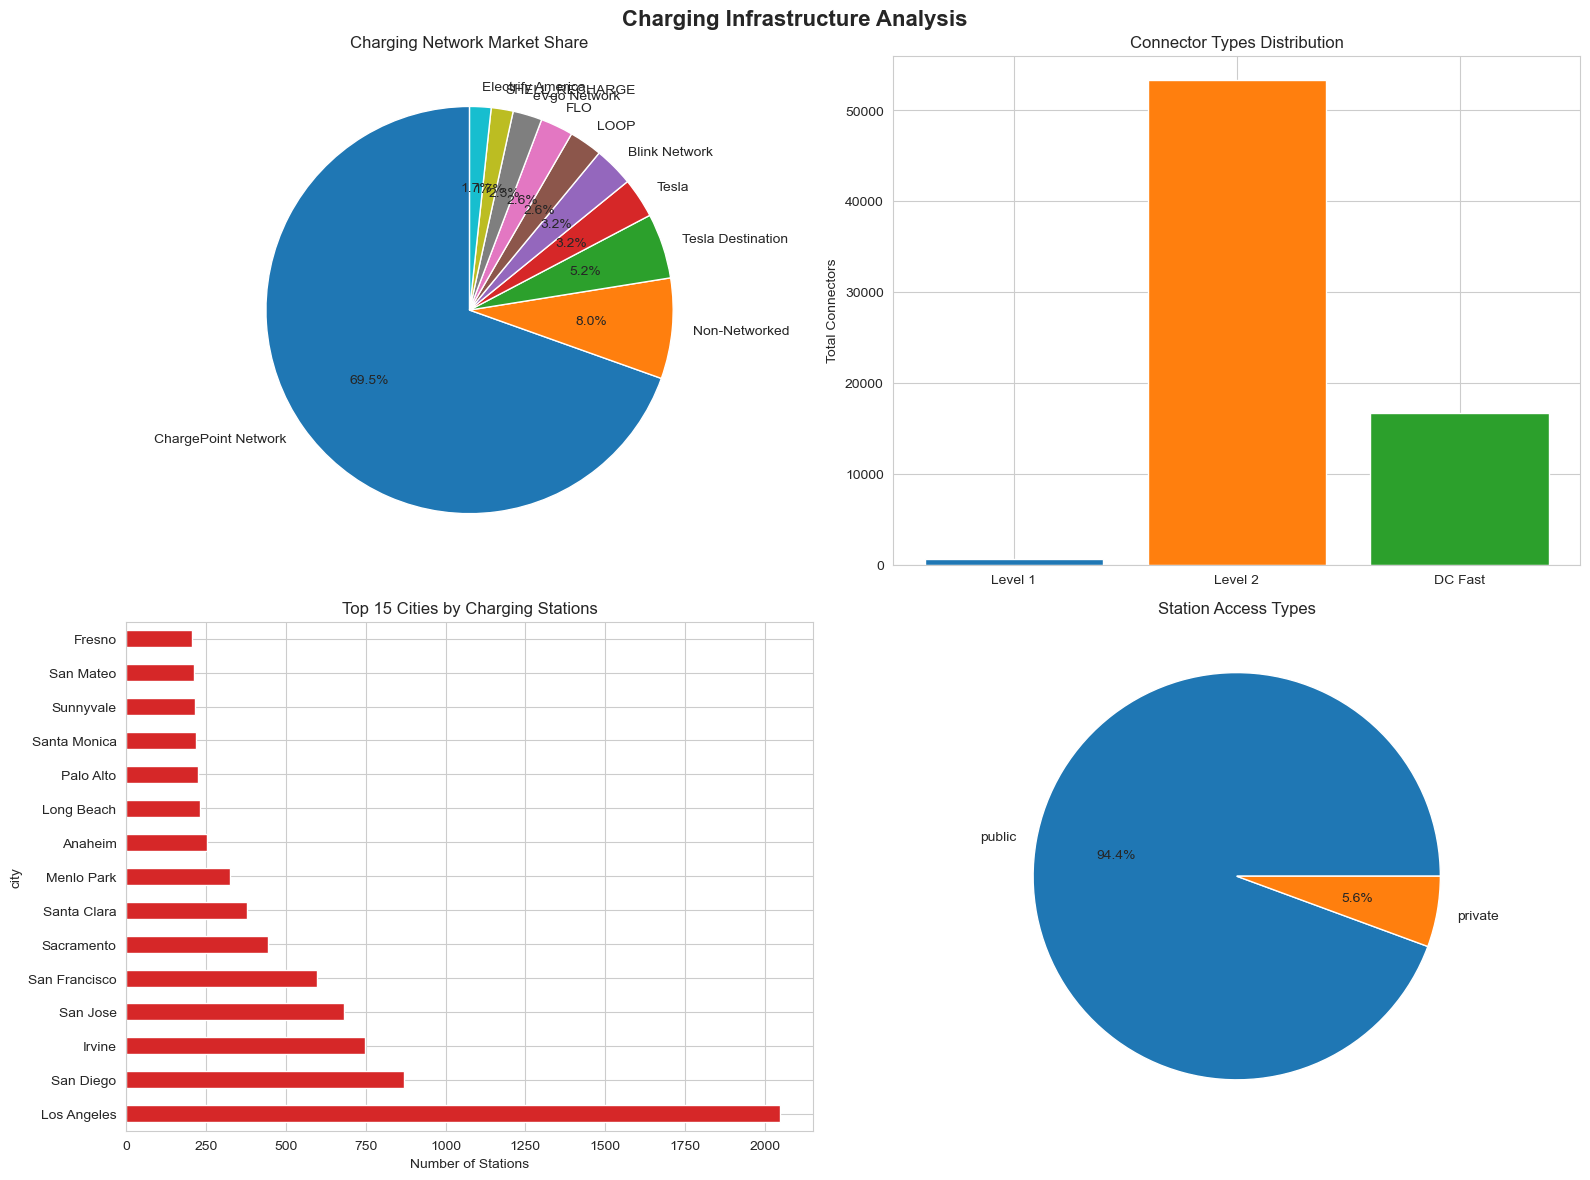


INFRASTRUCTURE INSIGHTS:
Total charging stations analyzed: 19,915
Total charging connectors: 70,657
Average connectors per station: 3.5
Stations with DC Fast charging: 2,653 (13.3%)
Market concentration (top network): 64.4%

Geographic coverage:
Latitude range: 32.54 to 41.96
Longitude range: -124.27 to -114.56


In [12]:
def analyze_charging_infrastructure():
    """Comprehensive charging infrastructure analysis"""
    
    print("\nCHARGING INFRASTRUCTURE ANALYSIS")
    print("=" * 50)
    
    # 1. Network distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Charging Infrastructure Analysis', fontsize=16, fontweight='bold')
    
    # Network market share
    network_counts = stations_df['network'].value_counts().head(10)
    network_counts.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('Charging Network Market Share')
    axes[0,0].set_ylabel('')
    
    # Connector types distribution
    stations_df['total_connectors'] = (stations_df['level1_count'] + 
                                     stations_df['level2_count'] + 
                                     stations_df['dc_fast_count'])
    
    connector_data = {
        'Level 1': stations_df['level1_count'].sum(),
        'Level 2': stations_df['level2_count'].sum(), 
        'DC Fast': stations_df['dc_fast_count'].sum()
    }
    
    axes[0,1].bar(connector_data.keys(), connector_data.values(), color=color_palette[:3])
    axes[0,1].set_title('Connector Types Distribution')
    axes[0,1].set_ylabel('Total Connectors')
    
    # Geographic distribution by city
    city_counts = stations_df['city'].value_counts().head(15)
    city_counts.plot(kind='barh', ax=axes[1,0], color=color_palette[3])
    axes[1,0].set_title('Top 15 Cities by Charging Stations')
    axes[1,0].set_xlabel('Number of Stations')
    
    # Access type distribution
    if 'access_code' in stations_df.columns:
        access_counts = stations_df['access_code'].value_counts()
        axes[1,1].pie(access_counts.values, labels=access_counts.index, autopct='%1.1f%%')
        axes[1,1].set_title('Station Access Types')
    
    plt.tight_layout()
    save_current_figure("ev_charging_infrastructure")
    plt.show()
    
    # Advanced analysis
    print("\nINFRASTRUCTURE INSIGHTS:")
    total_stations = len(stations_df)
    total_connectors = stations_df['total_connectors'].sum()
    
    print(f"Total charging stations analyzed: {total_stations:,}")
    print(f"Total charging connectors: {total_connectors:,}")
    print(f"Average connectors per station: {total_connectors/total_stations:.1f}")
    
    # DC Fast charging analysis
    dc_fast_stations = stations_df[stations_df['dc_fast_count'] > 0]
    print(f"Stations with DC Fast charging: {len(dc_fast_stations):,} ({len(dc_fast_stations)/total_stations*100:.1f}%)")
    
    # Network concentration analysis
    network_concentration = stations_df['network'].value_counts().iloc[0] / total_stations
    print(f"Market concentration (top network): {network_concentration*100:.1f}%")
    
    # Geographic analysis
    if 'latitude' in stations_df.columns and 'longitude' in stations_df.columns:
        print(f"\nGeographic coverage:")
        print(f"Latitude range: {stations_df['latitude'].min():.2f} to {stations_df['latitude'].max():.2f}")
        print(f"Longitude range: {stations_df['longitude'].min():.2f} to {stations_df['longitude'].max():.2f}")

if 'stations_df' in globals():
    analyze_charging_infrastructure()


EV MARKET GROWTH ANALYSIS
Saved: outputs/figures/ev_market_growth_20250831.png


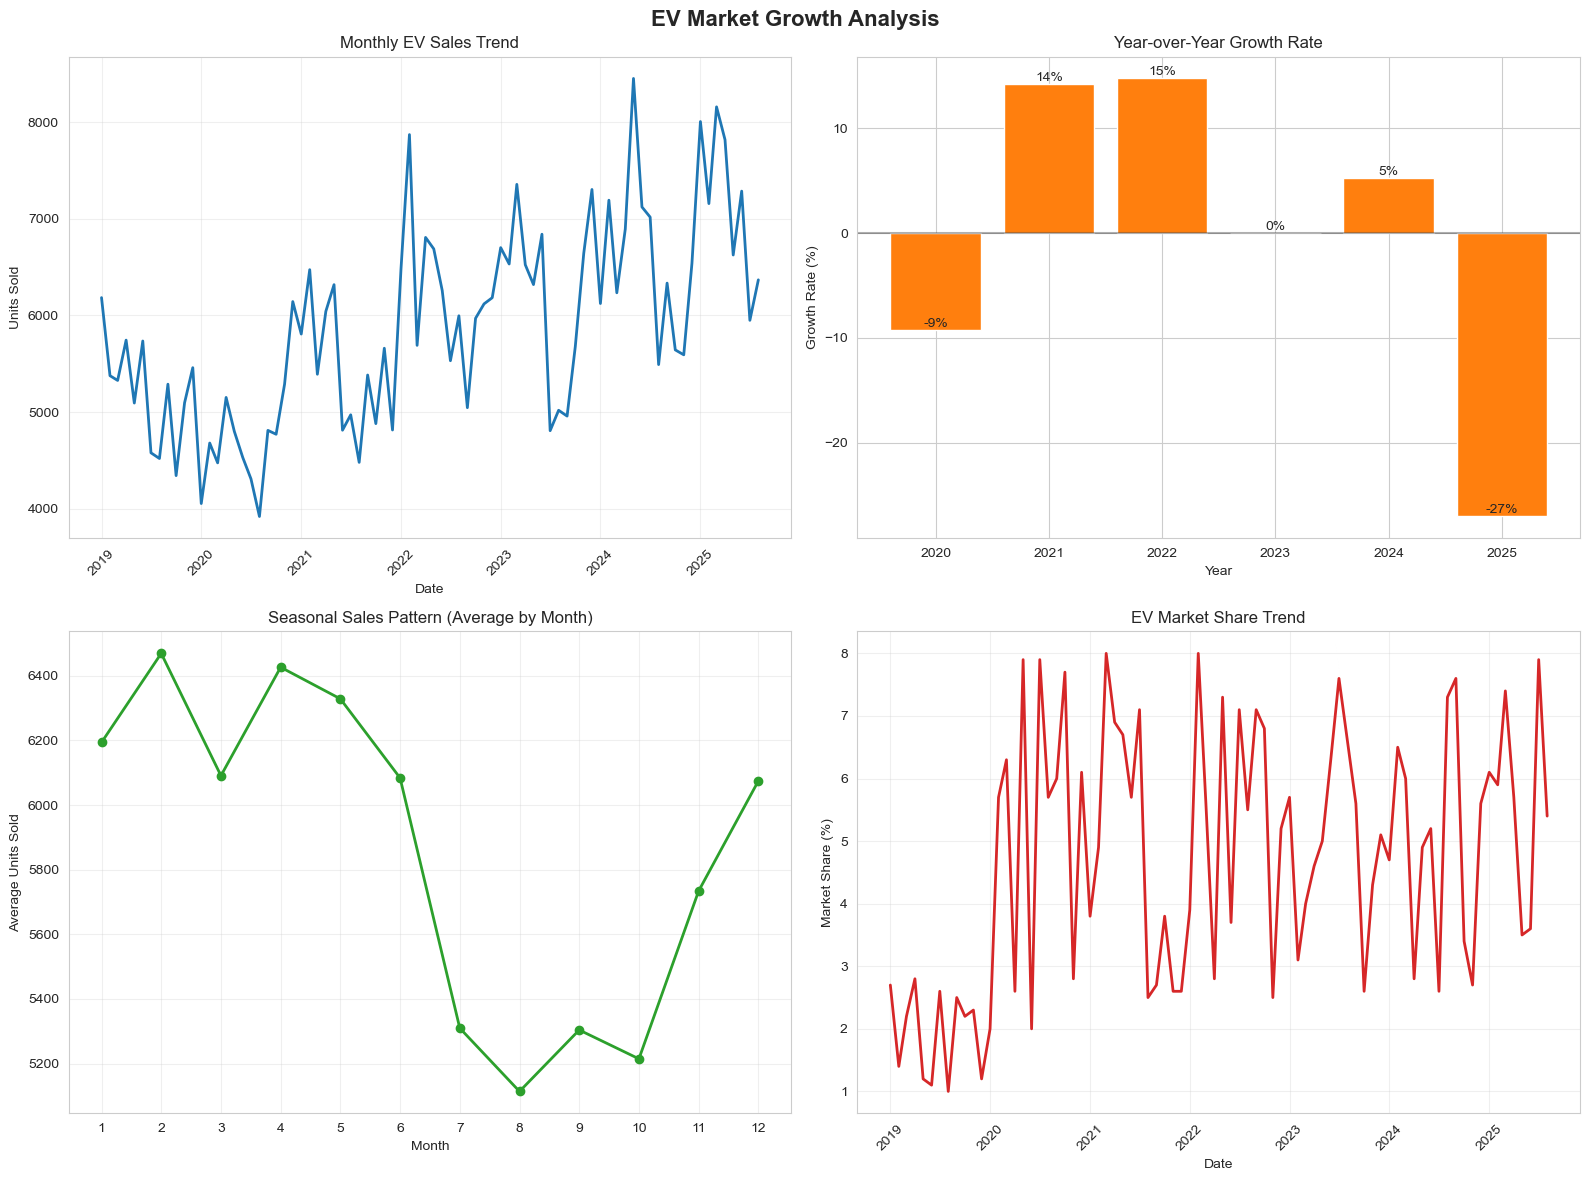


MARKET INSIGHTS:
Total EV sales (dataset period): 470,089 units
Compound Annual Growth Rate (CAGR): -1.5%
Most recent year-over-year growth: -27.0%
Peak sales month: 2 | Lowest: 8
Seasonal variation: 23.1%
Market share growth: 2.7% → 5.4% (+2.7pp)


In [14]:
def analyze_market_growth(sales_df, color_palette=None):
    """Comprehensive EV market growth and trends analysis"""
    
    if color_palette is None:
        color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # default colors
    
    print("\nEV MARKET GROWTH ANALYSIS")
    print("=" * 50)
    
    # Prepare time series data
    sales_df = sales_df.copy()
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    sales_df = sales_df.sort_values('date')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('EV Market Growth Analysis', fontsize=16, fontweight='bold')
    
    # 1. Monthly sales trend
    axes[0,0].plot(sales_df['date'], sales_df['total_ev_sales'], linewidth=2, color=color_palette[0])
    axes[0,0].set_title('Monthly EV Sales Trend')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Units Sold')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Year-over-year growth
    yearly_sales = sales_df.groupby('year')['total_ev_sales'].sum()
    yoy_growth = yearly_sales.pct_change() * 100
    
    bars = axes[0,1].bar(yoy_growth.index[1:], yoy_growth.values[1:], color=color_palette[1])
    axes[0,1].set_title('Year-over-Year Growth Rate')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Growth Rate (%)')
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.0f}%', ha='center', va='bottom')
    
    # 3. Seasonal analysis
    monthly_avg = sales_df.groupby('month')['total_ev_sales'].mean()
    axes[1,0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, color=color_palette[2])
    axes[1,0].set_title('Seasonal Sales Pattern (Average by Month)')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Average Units Sold')
    axes[1,0].set_xticks(range(1, 13))
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Market share trend
    if 'market_share_percent' in sales_df.columns:
        axes[1,1].plot(sales_df['date'], sales_df['market_share_percent'], 
                       linewidth=2, color=color_palette[3])
        axes[1,1].set_title('EV Market Share Trend')
        axes[1,1].set_xlabel('Date')
        axes[1,1].set_ylabel('Market Share (%)')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    save_current_figure("ev_market_growth")
    plt.show()
    
    # Growth metrics
    print("\nMARKET INSIGHTS:")
    total_sales = sales_df['total_ev_sales'].sum()
    print(f"Total EV sales (dataset period): {total_sales:,} units")
    
    # Calculate CAGR (Compound Annual Growth Rate)
    first_year_sales = yearly_sales.iloc[0]
    last_year_sales = yearly_sales.iloc[-1]
    years = len(yearly_sales) - 1
    if years > 0 and first_year_sales > 0:
        cagr = (last_year_sales / first_year_sales) ** (1/years) - 1
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.1f}%")
    
    # Recent growth
    if len(yoy_growth) > 1:
        recent_growth = yoy_growth.iloc[-1]
        print(f"Most recent year-over-year growth: {recent_growth:.1f}%")
    
    # Seasonal insights
    peak_month = monthly_avg.idxmax()
    low_month = monthly_avg.idxmin()
    seasonality = (monthly_avg.max() - monthly_avg.min()) / monthly_avg.mean() * 100
    print(f"Peak sales month: {peak_month} | Lowest: {low_month}")
    print(f"Seasonal variation: {seasonality:.1f}%")
    
    # Market share analysis
    if 'market_share_percent' in sales_df.columns:
        current_share = sales_df['market_share_percent'].iloc[-1]
        first_share = sales_df['market_share_percent'].iloc[0]
        share_growth = current_share - first_share
        print(f"Market share growth: {first_share:.1f}% → {current_share:.1f}% (+{share_growth:.1f}pp)")

# Call it like this
if 'sales_df' in globals():
    analyze_market_growth(sales_df, color_palette)



PREDICTIVE ANALYSIS & FORECASTING


17:46:16 - cmdstanpy - INFO - Chain [1] start processing
17:46:16 - cmdstanpy - INFO - Chain [1] done processing


Saved: outputs/figures/ev_trend_prediction_20250831.png


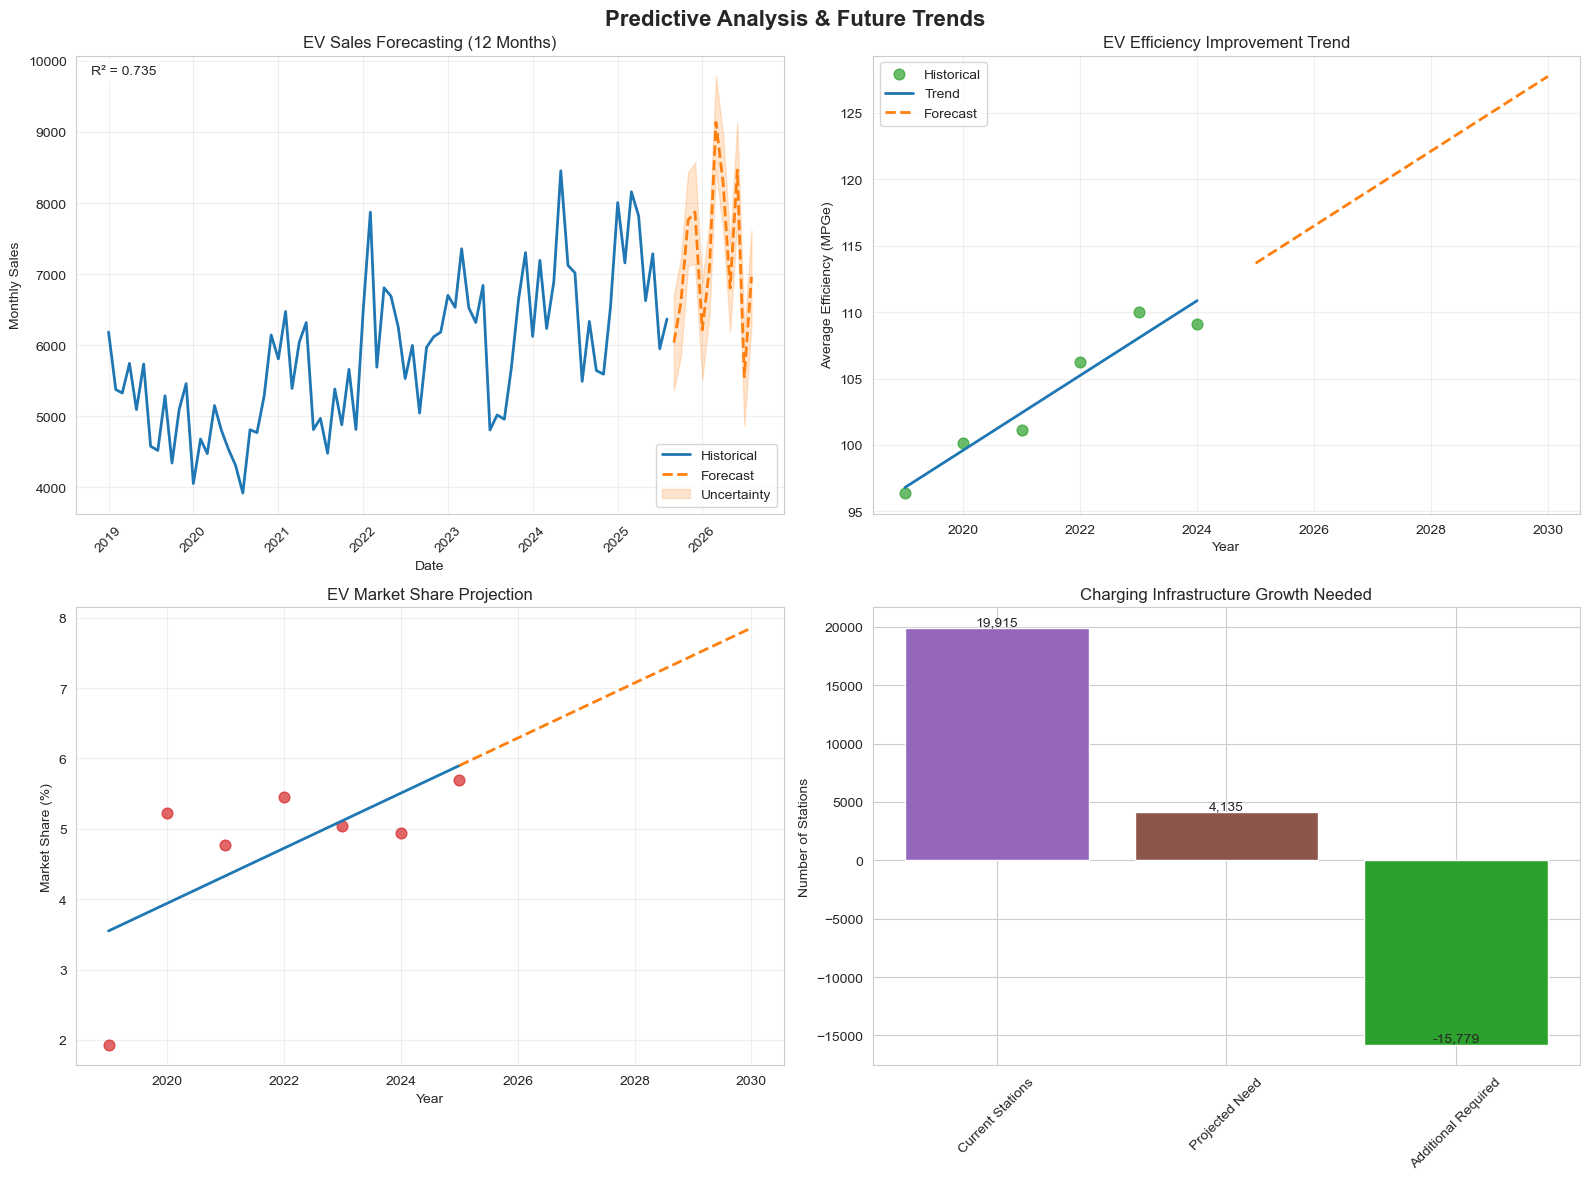


PREDICTIVE INSIGHTS:
Next 12 months projected sales: 86,771 units
Average monthly growth rate: 49 units/month
Projected 2030 efficiency: 128 MPGe
Projected 2030 market share: 7.9%

INFRASTRUCTURE INSIGHTS:
Current stations per 1,000 EVs: 53.0
Additional stations needed (next 12 months): -15,779
Required infrastructure growth rate: -79.2%


In [32]:
import sys
!{sys.executable} -m pip install prophet

def predictive_analysis():
    """Predictive modeling for EV trends and forecasting"""
    
    # Add these imports at the beginning of the function
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    import numpy as np
    import pandas as pd
    
    print("\nPREDICTIVE ANALYSIS & FORECASTING")
    print("=" * 50)
    
    # --- Ensure 'date' is datetime ---
    sales_df_sorted = sales_df.copy()
    sales_df_sorted['date'] = pd.to_datetime(sales_df_sorted['date'])
    sales_df_sorted = sales_df_sorted.sort_values('date')
    
    # 1. Sales forecasting using Facebook Prophet
    # Using Prophet for time series forecasting as it better handles
    # seasonality and trends compared to simple linear regression
    try:
        from prophet import Prophet

        # Prophet requires specific column names: 'ds' for date and 'y' for the value
        prophet_df = sales_df_sorted[['date', 'total_ev_sales']].copy()
        prophet_df.columns = ['ds', 'y']  # Rename columns for Prophet

        # Create and fit the model
        prophet_model = Prophet(
            yearly_seasonality=True,  # Captures yearly repeating patterns
            weekly_seasonality=False,  # Our data is monthly, so no weekly seasonality
            daily_seasonality=False
        )
        prophet_model.fit(prophet_df)

        # Create a future dataframe for 12 months
        future = prophet_model.make_future_dataframe(periods=12, freq='M')
        forecast = prophet_model.predict(future)

        # Extract the predictions for the future period
        future_forecast = forecast[forecast['ds'] > sales_df_sorted['date'].max()]
        future_predictions = future_forecast['yhat'].values
        future_dates = future_forecast['ds'].dt.to_pydatetime()  # Get the future dates

        # For plotting the historical fit, get the in-sample predictions
        train_predictions = forecast['yhat'].iloc[:len(sales_df_sorted)].values
        
        # Calculate R² score
        r2 = r2_score(sales_df_sorted['total_ev_sales'], train_predictions)
        
        # Calculate average monthly growth rate from Prophet forecast
        # Using the average change over the entire forecast period for a more stable estimate
        last_actual = sales_df_sorted['total_ev_sales'].iloc[-1]
        avg_monthly_growth = (future_predictions[-1] - last_actual) / len(future_predictions)
        
    except ImportError:
        print("Prophet not available. Falling back to linear regression.")
        # Fallback to linear regression
        sales_df_sorted['month_number'] = range(len(sales_df_sorted))
        
        X = sales_df_sorted['month_number'].values.reshape(-1, 1)
        y = sales_df_sorted['total_ev_sales'].values

        model = LinearRegression()
        model.fit(X, y)

        # Generate predictions for next 12 months
        last_month = sales_df_sorted['month_number'].max()
        future_months = np.arange(last_month + 1, last_month + 13).reshape(-1, 1)
        future_predictions = model.predict(future_months)
        future_dates = pd.date_range(start=sales_df_sorted['date'].max() + pd.DateOffset(months=1), 
                                     periods=12, freq='M')
        
        # For the fallback case, we don't have confidence intervals
        future_forecast = None
        
        # Model performance
        train_predictions = model.predict(X)
        r2 = r2_score(y, train_predictions)
        avg_monthly_growth = model.coef_[0]
    
    # --- Plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Predictive Analysis & Future Trends', fontsize=16, fontweight='bold')
    
    # Sales forecasting
    axes[0,0].plot(sales_df_sorted['date'], sales_df_sorted['total_ev_sales'], 
                   label='Historical', linewidth=2, color=color_palette[0])
    axes[0,0].plot(future_dates, future_predictions, 
                   label='Forecast', linewidth=2, linestyle='--', color=color_palette[1])
    
    # Add confidence intervals if using Prophet
    if 'future_forecast' in locals() and future_forecast is not None:
        axes[0,0].fill_between(future_dates, 
                              future_forecast['yhat_lower'].values,
                              future_forecast['yhat_upper'].values,
                              color=color_palette[1], alpha=0.2, label='Uncertainty')
    
    axes[0,0].set_title('EV Sales Forecasting (12 Months)')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Monthly Sales')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Model performance
    axes[0,0].text(0.02, 0.98, f'R² = {r2:.3f}', transform=axes[0,0].transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # --- 2. Efficiency improvement trend ---
    yearly_efficiency = vehicles_df.groupby('year')['combined_mpg'].mean()
    
    X_eff = yearly_efficiency.index.values.reshape(-1, 1)
    y_eff = yearly_efficiency.values
    eff_model = LinearRegression().fit(X_eff, y_eff)
    
    future_years = np.arange(2025, 2031).reshape(-1, 1)
    future_efficiency = eff_model.predict(future_years)
    
    axes[0,1].scatter(yearly_efficiency.index, yearly_efficiency.values, 
                      s=60, color=color_palette[2], label='Historical', alpha=0.7)
    axes[0,1].plot(yearly_efficiency.index, eff_model.predict(X_eff), 
                   color=color_palette[0], linewidth=2, label='Trend')
    axes[0,1].plot(future_years.flatten(), future_efficiency, 
                   linestyle='--', color=color_palette[1], linewidth=2, label='Forecast')
    axes[0,1].set_title('EV Efficiency Improvement Trend')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Average Efficiency (MPGe)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # --- 3. Market share projection ---
    if 'market_share_percent' in sales_df.columns:
        market_share_trend = sales_df.groupby('year')['market_share_percent'].mean()
        
        X_share = market_share_trend.index.values.reshape(-1, 1)
        y_share = market_share_trend.values
        share_model = LinearRegression().fit(X_share, y_share)
        
        future_share = share_model.predict(future_years)
        
        axes[1,0].scatter(market_share_trend.index, market_share_trend.values, 
                          s=60, color=color_palette[3], alpha=0.7)
        axes[1,0].plot(market_share_trend.index, share_model.predict(X_share), 
                       color=color_palette[0], linewidth=2)
        axes[1,0].plot(future_years.flatten(), future_share, 
                       linestyle='--', color=color_palette[1], linewidth=2)
        axes[1,0].set_title('EV Market Share Projection')
        axes[1,0].set_xlabel('Year')
        axes[1,0].set_ylabel('Market Share (%)')
        axes[1,0].grid(True, alpha=0.3)
    
    # --- 4. Charging infrastructure growth needed ---
    total_stations = len(stations_df)
    estimated_evs_on_road = sales_df['total_ev_sales'].sum() * 0.8
    stations_per_1000_evs = (total_stations / estimated_evs_on_road) * 1000
    
    future_ev_sales = future_predictions.sum()
    future_evs_needed = future_ev_sales * 0.9
    projected_stations_needed = (future_evs_needed / 1000) * stations_per_1000_evs
    
    infrastructure_data = {
        'Current Stations': total_stations,
        'Projected Need': int(projected_stations_needed),
        'Additional Required': int(projected_stations_needed - total_stations)
    }
    
    bars = axes[1,1].bar(infrastructure_data.keys(), infrastructure_data.values(), 
                         color=[color_palette[4], color_palette[5], color_palette[2]])
    axes[1,1].set_title('Charging Infrastructure Growth Needed')
    axes[1,1].set_ylabel('Number of Stations')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}', ha='center', va='bottom')
    
    plt.tight_layout()
    save_current_figure("ev_trend_prediction")
    plt.show()
    
    # --- Predictive insights ---
    print("\nPREDICTIVE INSIGHTS:")
    print(f"Next 12 months projected sales: {future_predictions.sum():,.0f} units")
    print(f"Average monthly growth rate: {avg_monthly_growth:.0f} units/month")
    print(f"Projected 2030 efficiency: {eff_model.predict([[2030]])[0]:.0f} MPGe")
    
    if 'market_share_percent' in sales_df.columns:
        print(f"Projected 2030 market share: {share_model.predict([[2030]])[0]:.1f}%")
    
    print(f"\nINFRASTRUCTURE INSIGHTS:")
    print(f"Current stations per 1,000 EVs: {stations_per_1000_evs:.1f}")
    print(f"Additional stations needed (next 12 months): {infrastructure_data['Additional Required']:,}")
    
    growth_rate_needed = (infrastructure_data['Additional Required'] / total_stations) * 100
    print(f"Required infrastructure growth rate: {growth_rate_needed:.1f}%")

# Call
if 'sales_df' in globals():
    predictive_analysis()


COMPETITIVE ANALYSIS
Saved: outputs/figures/ev_manufacturer_competition_20250831.png


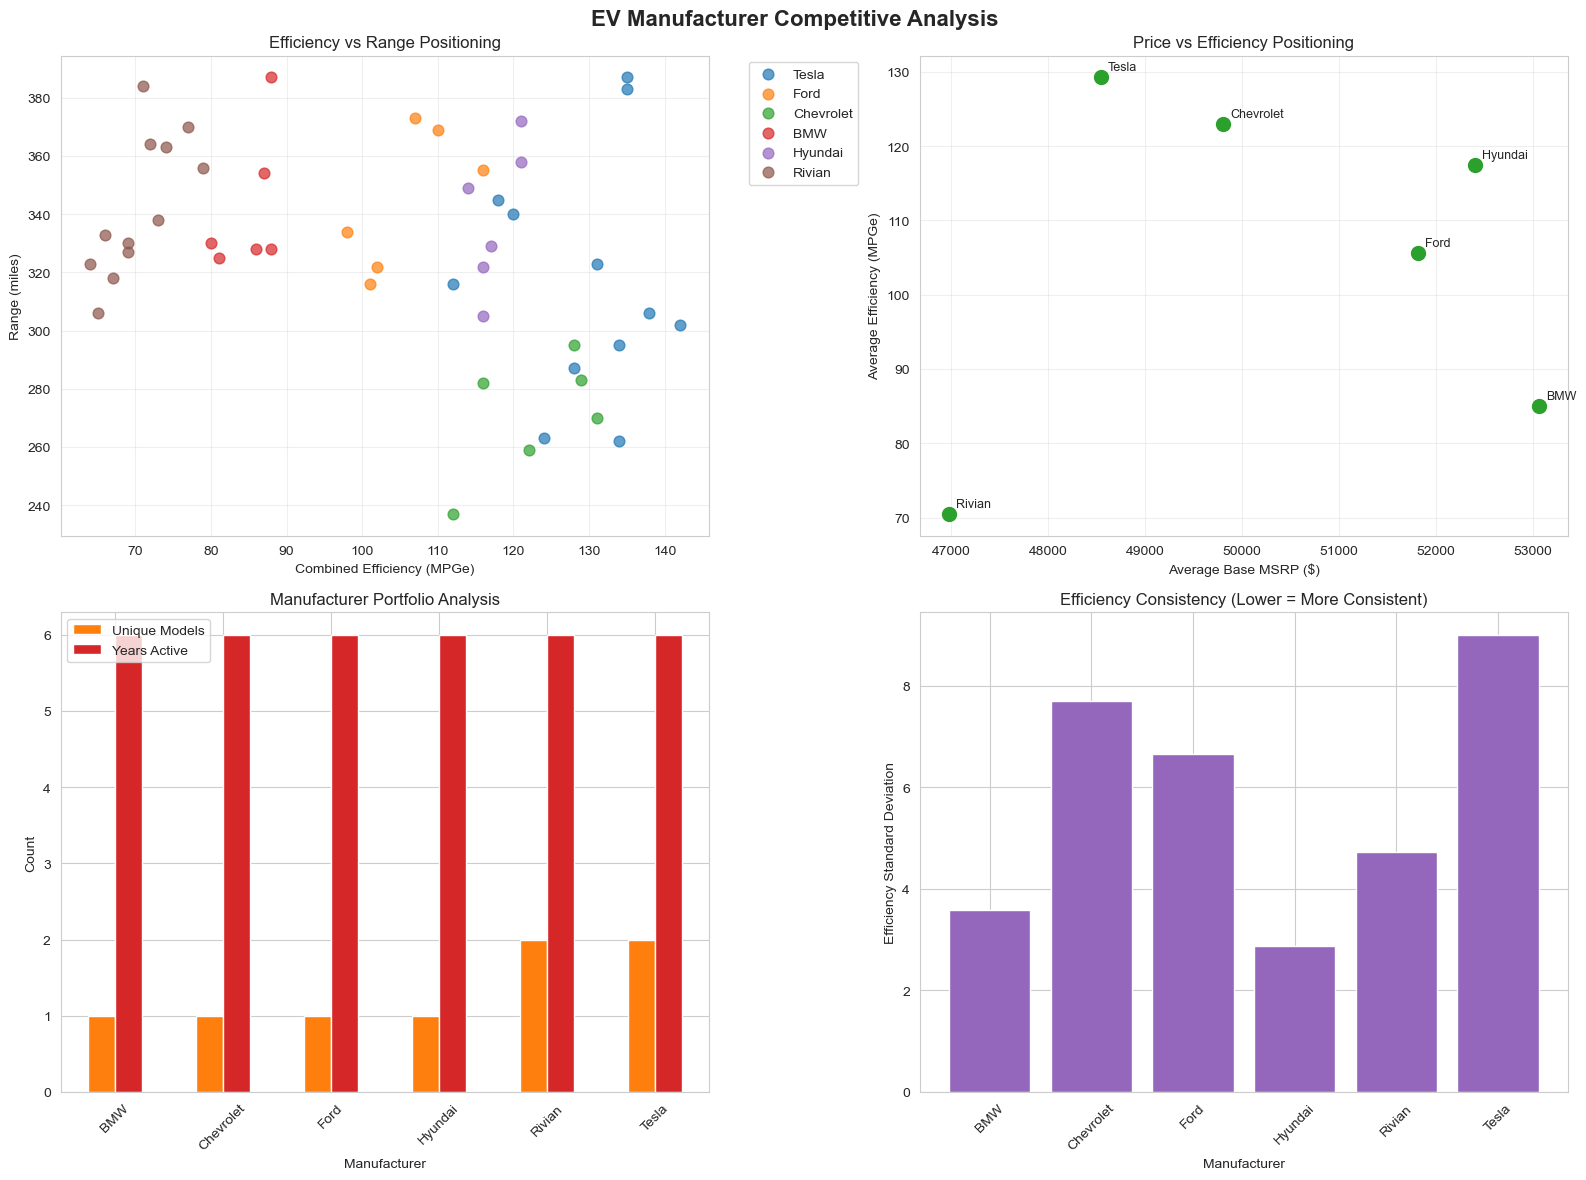


COMPETITIVE INSIGHTS:
Efficiency leader: Tesla
Range leader: Ford
Value leader (efficiency/price): Tesla

POSITIONING MATRIX:
Tesla: Mass Market | High Efficiency | Avg Range: 317mi
Ford: Premium | Standard Efficiency | Avg Range: 345mi
Chevrolet: Premium | High Efficiency | Avg Range: 271mi
BMW: Premium | Standard Efficiency | Avg Range: 342mi
Hyundai: Premium | High Efficiency | Avg Range: 339mi
Rivian: Mass Market | Standard Efficiency | Avg Range: 343mi


In [34]:
def competitive_analysis():
    """Advanced competitive analysis of EV manufacturers"""
    
    print("\nCOMPETITIVE ANALYSIS")
    print("=" * 50)
    
    # Create comprehensive manufacturer analysis
    manufacturer_metrics = vehicles_df.groupby('make').agg({
        'combined_mpg': ['mean', 'std'],
        'range_miles': ['mean', 'max'], 
        'year': 'count',
        'msrp_base': ['mean', 'min', 'max']
    }).round(2)
    
    # Flatten column names
    manufacturer_metrics.columns = ['_'.join(col).strip() for col in manufacturer_metrics.columns]
    manufacturer_metrics = manufacturer_metrics.reset_index()
    
    # Create competitive positioning chart
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('EV Manufacturer Competitive Analysis', fontsize=16, fontweight='bold')
    
    # 1. Efficiency vs Range positioning
    for i, make in enumerate(vehicles_df['make'].unique()):
        make_data = vehicles_df[vehicles_df['make'] == make]
        axes[0,0].scatter(make_data['combined_mpg'], make_data['range_miles'], 
                         label=make, alpha=0.7, s=60, color=color_palette[i % len(color_palette)])
    
    axes[0,0].set_xlabel('Combined Efficiency (MPGe)')
    axes[0,0].set_ylabel('Range (miles)')
    axes[0,0].set_title('Efficiency vs Range Positioning')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Price positioning
    price_efficiency = vehicles_df.groupby('make')[['msrp_base', 'combined_mpg']].mean()
    price_efficiency.plot.scatter(x='msrp_base', y='combined_mpg', 
                                 s=100, ax=axes[0,1], color=color_palette[2])
    
    # Add manufacturer labels
    for idx, row in price_efficiency.iterrows():
        axes[0,1].annotate(idx, (row['msrp_base'], row['combined_mpg']), 
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[0,1].set_xlabel('Average Base MSRP ($)')
    axes[0,1].set_ylabel('Average Efficiency (MPGe)')
    axes[0,1].set_title('Price vs Efficiency Positioning')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Model portfolio breadth
    portfolio_breadth = vehicles_df.groupby('make').agg({
        'model': 'nunique',
        'year': lambda x: x.max() - x.min() + 1
    })
    portfolio_breadth.columns = ['Models', 'Years_Active']
    
    portfolio_breadth.plot.bar(ax=axes[1,0], color=[color_palette[1], color_palette[3]])
    axes[1,0].set_title('Manufacturer Portfolio Analysis')
    axes[1,0].set_xlabel('Manufacturer')
    axes[1,0].set_ylabel('Count')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend(['Unique Models', 'Years Active'])
    
    # 4. Performance consistency (efficiency std dev)
    consistency_data = vehicles_df.groupby('make')['combined_mpg'].agg(['mean', 'std'])
    bars = axes[1,1].bar(consistency_data.index, consistency_data['std'], color=color_palette[4])
    axes[1,1].set_title('Efficiency Consistency (Lower = More Consistent)')
    axes[1,1].set_xlabel('Manufacturer')
    axes[1,1].set_ylabel('Efficiency Standard Deviation')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    save_current_figure("ev_manufacturer_competition")
    plt.show()
    
    # Competitive insights
    print("\nCOMPETITIVE INSIGHTS:")
    
    # Market leaders
    efficiency_leader = vehicles_df.groupby('make')['combined_mpg'].mean().idxmax()
    range_leader = vehicles_df.groupby('make')['range_miles'].mean().idxmax()
    value_leader = vehicles_df.assign(value_score=vehicles_df['combined_mpg']/vehicles_df['msrp_base']*100000).groupby('make')['value_score'].mean().idxmax()
    
    print(f"Efficiency leader: {efficiency_leader}")
    print(f"Range leader: {range_leader}")
    print(f"Value leader (efficiency/price): {value_leader}")
    
    # Market positioning analysis
    print(f"\nPOSITIONING MATRIX:")
    for make in vehicles_df['make'].unique():
        make_data = vehicles_df[vehicles_df['make'] == make]
        avg_price = make_data['msrp_base'].mean()
        avg_efficiency = make_data['combined_mpg'].mean()
        avg_range = make_data['range_miles'].mean()
        
        # Determine market segment
        if avg_price > vehicles_df['msrp_base'].median():
            price_segment = "Premium"
        else:
            price_segment = "Mass Market"
            
        if avg_efficiency > vehicles_df['combined_mpg'].median():
            efficiency_segment = "High Efficiency"
        else:
            efficiency_segment = "Standard Efficiency"
        
        print(f"{make}: {price_segment} | {efficiency_segment} | Avg Range: {avg_range:.0f}mi")

if 'vehicles_df' in globals():
    competitive_analysis()


MANUFACTURER EFFICIENCY TREND ANALYSIS

Manufacturer Efficiency Trends:
--------------------------------------------------------------------------------
> Tesla        |      129.2 |       3.90 |     3.02% |      6 |   0.833 <-- LEADER
  Chevrolet    |      123.0 |       3.71 |     3.02% |      6 |   0.816
  Hyundai      |      117.5 |       1.23 |     1.05% |      6 |   0.636
  Ford         |      105.7 |       3.49 |     3.30% |      6 |   0.961
  BMW          |       85.0 |       1.71 |     2.02% |      6 |   0.804
  Rivian       |       70.5 |       2.29 |     3.24% |      6 |   0.768
Saved: outputs/figures/manufacturer_efficiency_trends_20250831.png


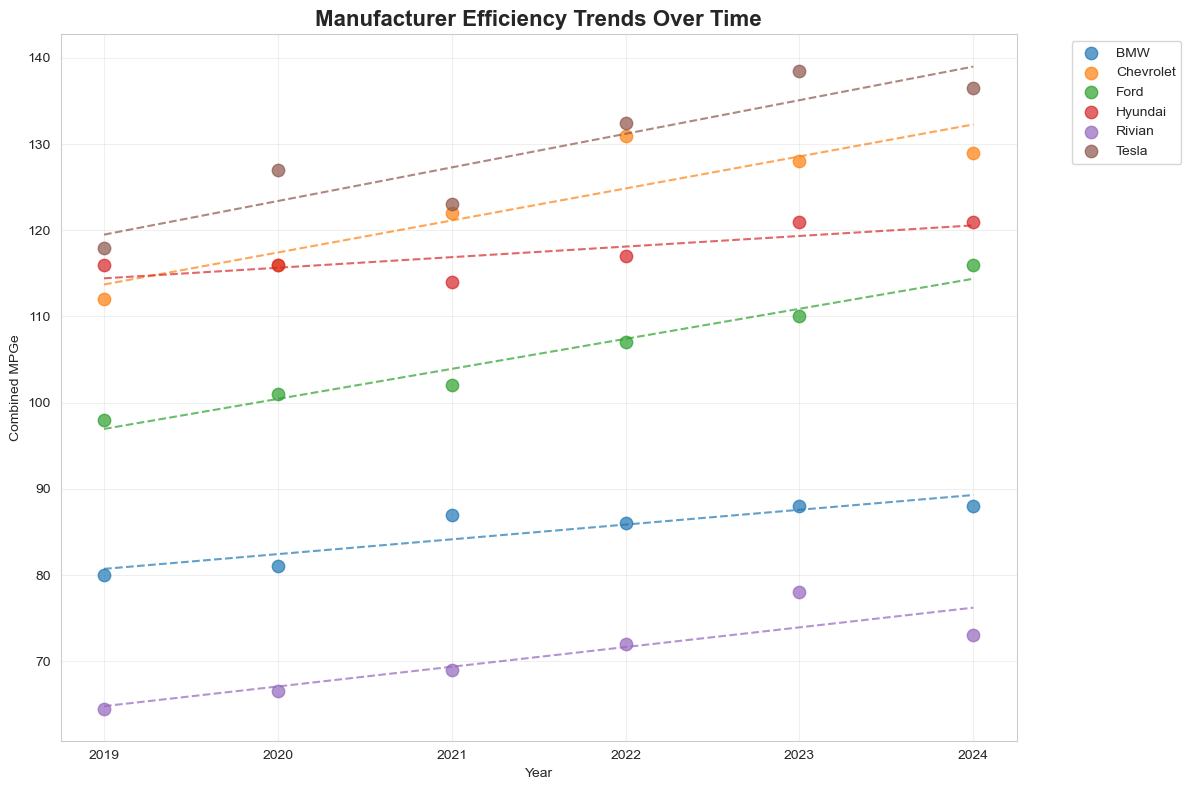


KEY INSIGHTS:
- Efficiency leader: Tesla (129.2 MPGe)
- Most improved: Ford (3.30% annual improvement)
- Industry average improvement: 2.61% per year


In [36]:
def analyze_manufacturer_efficiency_trends():
    """Analyze MPGe trends by manufacturer with annual improvement rates"""
    
    print("\nMANUFACTURER EFFICIENCY TREND ANALYSIS")
    print("=" * 50)
    
    # Check if we have the necessary data
    if 'make' not in vehicles_df.columns or 'year' not in vehicles_df.columns or 'combined_mpg' not in vehicles_df.columns:
        print("Required columns (make, year, combined_mpg) not found in dataset")
        return
    
    # Compute yearly averages by manufacturer
    manufacturer_yearly_avg = vehicles_df.groupby(['make', 'year'])['combined_mpg'].mean().reset_index()
    
    # Prepare results table
    results = []
    
    # Analyze each manufacturer
    for manufacturer in manufacturer_yearly_avg['make'].unique():
        mfg_data = manufacturer_yearly_avg[manufacturer_yearly_avg['make'] == manufacturer]
        
        # Need at least 2 years of data to calculate trend
        if len(mfg_data) < 2:
            continue
            
        # Extract years and efficiency values
        years = mfg_data['year'].values
        efficiencies = mfg_data['combined_mpg'].values
        
        # Fit linear regression
        X = years.reshape(-1, 1)
        y = efficiencies
        model = LinearRegression()
        model.fit(X, y)
        
        # Calculate trend metrics
        slope = model.coef_[0]  # Annual MPGe improvement
        avg_mpge = np.mean(efficiencies)
        annual_improvement_pct = (slope / avg_mpge) * 100 if avg_mpge > 0 else 0
        
        # Calculate R-squared for goodness of fit
        r_squared = model.score(X, y)
        
        # Add to results
        results.append({
            'Manufacturer': manufacturer,
            'Average MPGe': round(avg_mpge, 1),
            'Annual Improvement (MPGe)': round(slope, 2),
            'Annual Improvement (%)': round(annual_improvement_pct, 2),
            'Data Points': len(mfg_data),
            'R-squared': round(r_squared, 3)
        })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Sort by efficiency (highest first)
    results_df = results_df.sort_values('Average MPGe', ascending=False)
    
    # Display results
    print("\nManufacturer Efficiency Trends:")
    print("-" * 80)
    
    # Format the table for better readability
    display_cols = ['Manufacturer', 'Average MPGe', 'Annual Improvement (MPGe)', 
                   'Annual Improvement (%)', 'Data Points', 'R-squared']
    
    # Highlight the leader (Tesla or highest efficiency)
    leader = results_df.iloc[0]['Manufacturer']
    
    for _, row in results_df.iterrows():
        if row['Manufacturer'] == leader:
            # Highlight the leader
            print(f"> {row['Manufacturer']:12} | {row['Average MPGe']:10.1f} | "
                  f"{row['Annual Improvement (MPGe)']:10.2f} | {row['Annual Improvement (%)']:8.2f}% | "
                  f"{row['Data Points']:6} | {row['R-squared']:7.3f} <-- LEADER")
        else:
            print(f"  {row['Manufacturer']:12} | {row['Average MPGe']:10.1f} | "
                  f"{row['Annual Improvement (MPGe)']:10.2f} | {row['Annual Improvement (%)']:8.2f}% | "
                  f"{row['Data Points']:6} | {row['R-squared']:7.3f}")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Plot each manufacturer's trend
    for manufacturer in manufacturer_yearly_avg['make'].unique():
        mfg_data = manufacturer_yearly_avg[manufacturer_yearly_avg['make'] == manufacturer]
        if len(mfg_data) < 2:
            continue
            
        # Plot actual data points
        plt.scatter(mfg_data['year'], mfg_data['combined_mpg'], label=manufacturer, s=80, alpha=0.7)
        
        # Plot trend line
        years = mfg_data['year'].values
        X = years.reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, mfg_data['combined_mpg'].values)
        trend_years = np.array([min(years), max(years)])
        trend_line = model.predict(trend_years.reshape(-1, 1))
        
        plt.plot(trend_years, trend_line, linestyle='--', alpha=0.7)
    
    plt.title('Manufacturer Efficiency Trends Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Combined MPGe')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    save_current_figure("manufacturer_efficiency_trends")
    plt.show()
    
    # Additional insights
    print(f"\nKEY INSIGHTS:")
    print(f"- Efficiency leader: {leader} ({results_df.iloc[0]['Average MPGe']} MPGe)")
    
    # Find most improved manufacturer
    most_improved = results_df.loc[results_df['Annual Improvement (%)'].idxmax()]
    print(f"- Most improved: {most_improved['Manufacturer']} ({most_improved['Annual Improvement (%)']:.2f}% annual improvement)")
    
    # Industry average improvement
    industry_avg_improvement = results_df['Annual Improvement (%)'].mean()
    print(f"- Industry average improvement: {industry_avg_improvement:.2f}% per year")
    
    return results_df

# Add this function to your analysis workflow
if 'vehicles_df' in globals():
    manufacturer_trends = analyze_manufacturer_efficiency_trends()


URBAN VS RURAL CHARGING INFRASTRUCTURE ANALYSIS

Charging Station Distribution:
----------------------------------------
Rural: 15513 stations (77.9%)
Urban: 4402 stations (22.1%)

DC Fast Charging by Area Type:
----------------------------------------
Rural: 14714 DC fast connectors (88.3%)
Urban: 1953 DC fast connectors (11.7%)

Map saved as outputs/figures/urban_rural_stations_map.html
Saved: outputs/figures/kmeans_elbow_plot_20250831.png


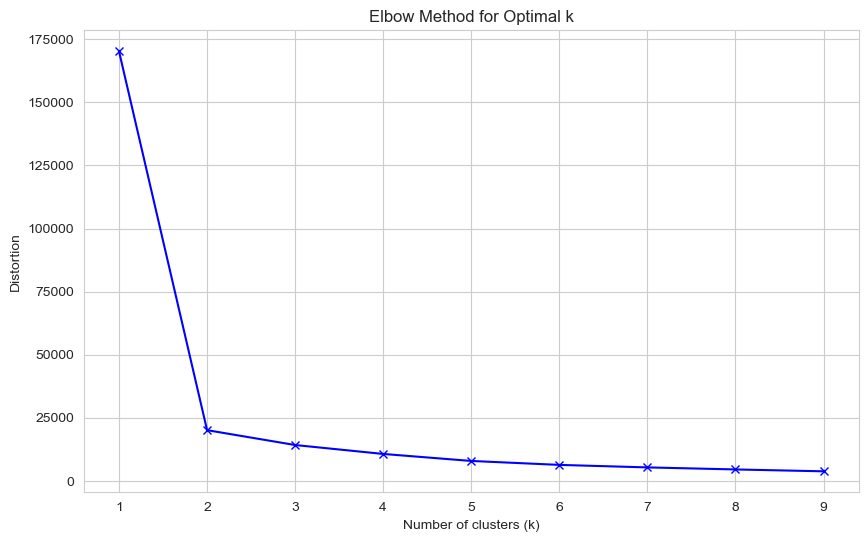


Cluster Analysis:
----------------------------------------
         Station_Count  Urban_Percentage  Avg_DC_Fast_Count
cluster                                                    
0                 8033             25.49               0.72
1                 6404             19.94               0.72
2                 2210             39.41               1.02
3                 1272             16.19               1.48
4                 1996              0.00               1.03

Underserved areas (clusters with < 50% of average station count):
Number of underserved clusters: 1
Cluster 3: 1272.0 stations


In [38]:
def analyze_urban_rural_distribution():
    """Analyze urban vs. rural distribution of charging stations"""
    
    print("\nURBAN VS RURAL CHARGING INFRASTRUCTURE ANALYSIS")
    print("=" * 60)
    
    # Check if we have the necessary data
    if 'latitude' not in stations_df.columns or 'longitude' not in stations_df.columns:
        print("ERROR: Latitude and longitude data required for geographic analysis")
        return
    
    # Define urban/rural classification based on population density
    # For California, we'll use approximate thresholds
    # This is a simplified approach - in a real analysis, you'd use official designations
    
    # Load California city population data (simplified for this example)
    # In a real implementation, you'd use a proper dataset
    ca_city_population = {
        'Los Angeles': 3970000,
        'San Diego': 1420000,
        'San Jose': 1030000,
        'San Francisco': 883000,
        'Fresno': 530000,
        # Add more cities as needed
    }
    
    # Classify stations as urban or rural
    stations_df['area_type'] = 'Rural'  # Default to rural
    
    for idx, row in stations_df.iterrows():
        city = row['city']
        if city in ca_city_population and ca_city_population[city] > 500000:
            stations_df.at[idx, 'area_type'] = 'Urban'
        elif city in ca_city_population and ca_city_population[city] > 100000:
            stations_df.at[idx, 'area_type'] = 'Suburban'
    
    # Count stations by area type
    area_counts = stations_df['area_type'].value_counts()
    
    print("\nCharging Station Distribution:")
    print("-" * 40)
    for area_type, count in area_counts.items():
        percentage = (count / len(stations_df)) * 100
        print(f"{area_type}: {count} stations ({percentage:.1f}%)")
    
    # Analyze DC fast charging by area type
    if 'dc_fast_count' in stations_df.columns:
        dc_fast_by_area = stations_df.groupby('area_type')['dc_fast_count'].sum()
        total_dc_fast = dc_fast_by_area.sum()
        
        print("\nDC Fast Charging by Area Type:")
        print("-" * 40)
        for area_type, count in dc_fast_by_area.items():
            percentage = (count / total_dc_fast) * 100
            print(f"{area_type}: {count} DC fast connectors ({percentage:.1f}%)")
    
    # Create folium map to visualize distribution
    try:
        # Calculate center of California for map
        ca_center = [36.7783, -119.4179]
        
        # Create base map
        m = folium.Map(location=ca_center, zoom_start=6, tiles='OpenStreetMap')
        
        # Add markers with different colors for urban/rural
        for idx, row in stations_df.iterrows():
            if row['area_type'] == 'Urban':
                color = 'red'
            elif row['area_type'] == 'Suburban':
                color = 'orange'
            else:
                color = 'green'
            
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=3,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7,
                popup=f"{row['station_name']} - {row['area_type']}"
            ).add_to(m)
        
        # Add legend
        legend_html = '''
            <div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 90px; 
            background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
            ">&nbsp; <b>Area Type</b> <br>
            &nbsp; Urban &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i><br>
            &nbsp; Suburban &nbsp; <i class="fa fa-circle fa-1x" style="color:orange"></i><br>
            &nbsp; Rural &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i>
            </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        # Save map
        m.save('outputs/figures/urban_rural_stations_map.html')
        print("\nMap saved as outputs/figures/urban_rural_stations_map.html")
        
    except Exception as e:
        print(f"Error creating map: {e}")
    
    # Perform K-means clustering to identify station clusters
    try:
        from sklearn.cluster import KMeans
        
        # Use coordinates for clustering
        coords = stations_df[['latitude', 'longitude']].values
        
        # Determine optimal number of clusters using elbow method
        distortions = []
        K = range(1, 10)
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(coords)
            distortions.append(kmeans.inertia_)
        
        # Plot elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Distortion')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        save_current_figure("kmeans_elbow_plot")
        plt.show()
        
        # Based on elbow method, choose k=5 (you might adjust this)
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        stations_df['cluster'] = kmeans.fit_predict(coords)
        
        # Analyze clusters
        cluster_analysis = stations_df.groupby('cluster').agg({
            'station_name': 'count',
            'area_type': lambda x: (x == 'Urban').sum() / len(x) * 100,
            'dc_fast_count': 'mean'
        }).round(2)
        
        cluster_analysis.columns = ['Station_Count', 'Urban_Percentage', 'Avg_DC_Fast_Count']
        
        print("\nCluster Analysis:")
        print("-" * 40)
        print(cluster_analysis)
        
        # Identify underserved areas (clusters with low station density)
        avg_stations_per_cluster = cluster_analysis['Station_Count'].mean()
        underserved_clusters = cluster_analysis[cluster_analysis['Station_Count'] < avg_stations_per_cluster * 0.5]
        
        print(f"\nUnderserved areas (clusters with < 50% of average station count):")
        print(f"Number of underserved clusters: {len(underserved_clusters)}")
        
        for cluster_id, row in underserved_clusters.iterrows():
            print(f"Cluster {cluster_id}: {row['Station_Count']} stations")
        
    except Exception as e:
        print(f"Error performing clustering: {e}")
    
    return area_counts

# Add this function to your analysis
if 'stations_df' in globals():
    urban_rural_distribution = analyze_urban_rural_distribution()


EV SEGMENTATION ANALYSIS USING K-MEANS CLUSTERING
Saved: outputs/figures/kmeans_elbow_ev_segmentation_20250831.png


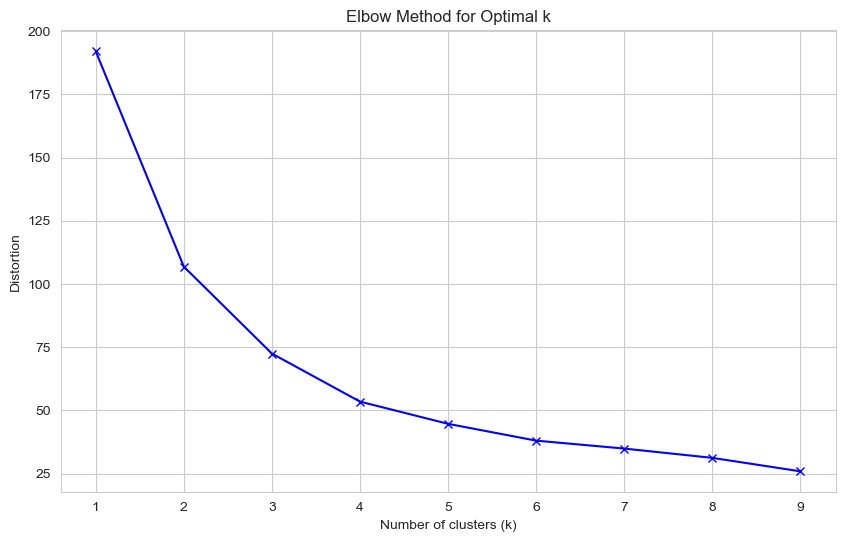

Using threshold value: 4.2568 for elbow detection
Elbow method suggests optimal k = 6

Cluster Characteristics:
----------------------------------------
         Avg_MPGe  Std_MPGe  Avg_Range  Std_Range  Avg_Price  Std_Price  \
cluster                                                                   
0          126.50      7.15     274.00      14.67   53036.67    2689.60   
1           72.58      7.40     336.92      20.81   45860.83    2043.86   
2           80.83      7.41     353.50      26.44   55302.17    3922.42   
3          129.83     10.40     282.83      25.83   44958.83    3294.07   
4          118.58     11.24     353.25      24.26   48590.50    2257.20   
5          111.17      7.60     326.50      17.10   55934.50    1551.79   

        Dominant_Make  
cluster                
0               Tesla  
1              Rivian  
2                 BMW  
3               Tesla  
4               Tesla  
5             Hyundai  

Cluster Interpretation:
-----------------------------

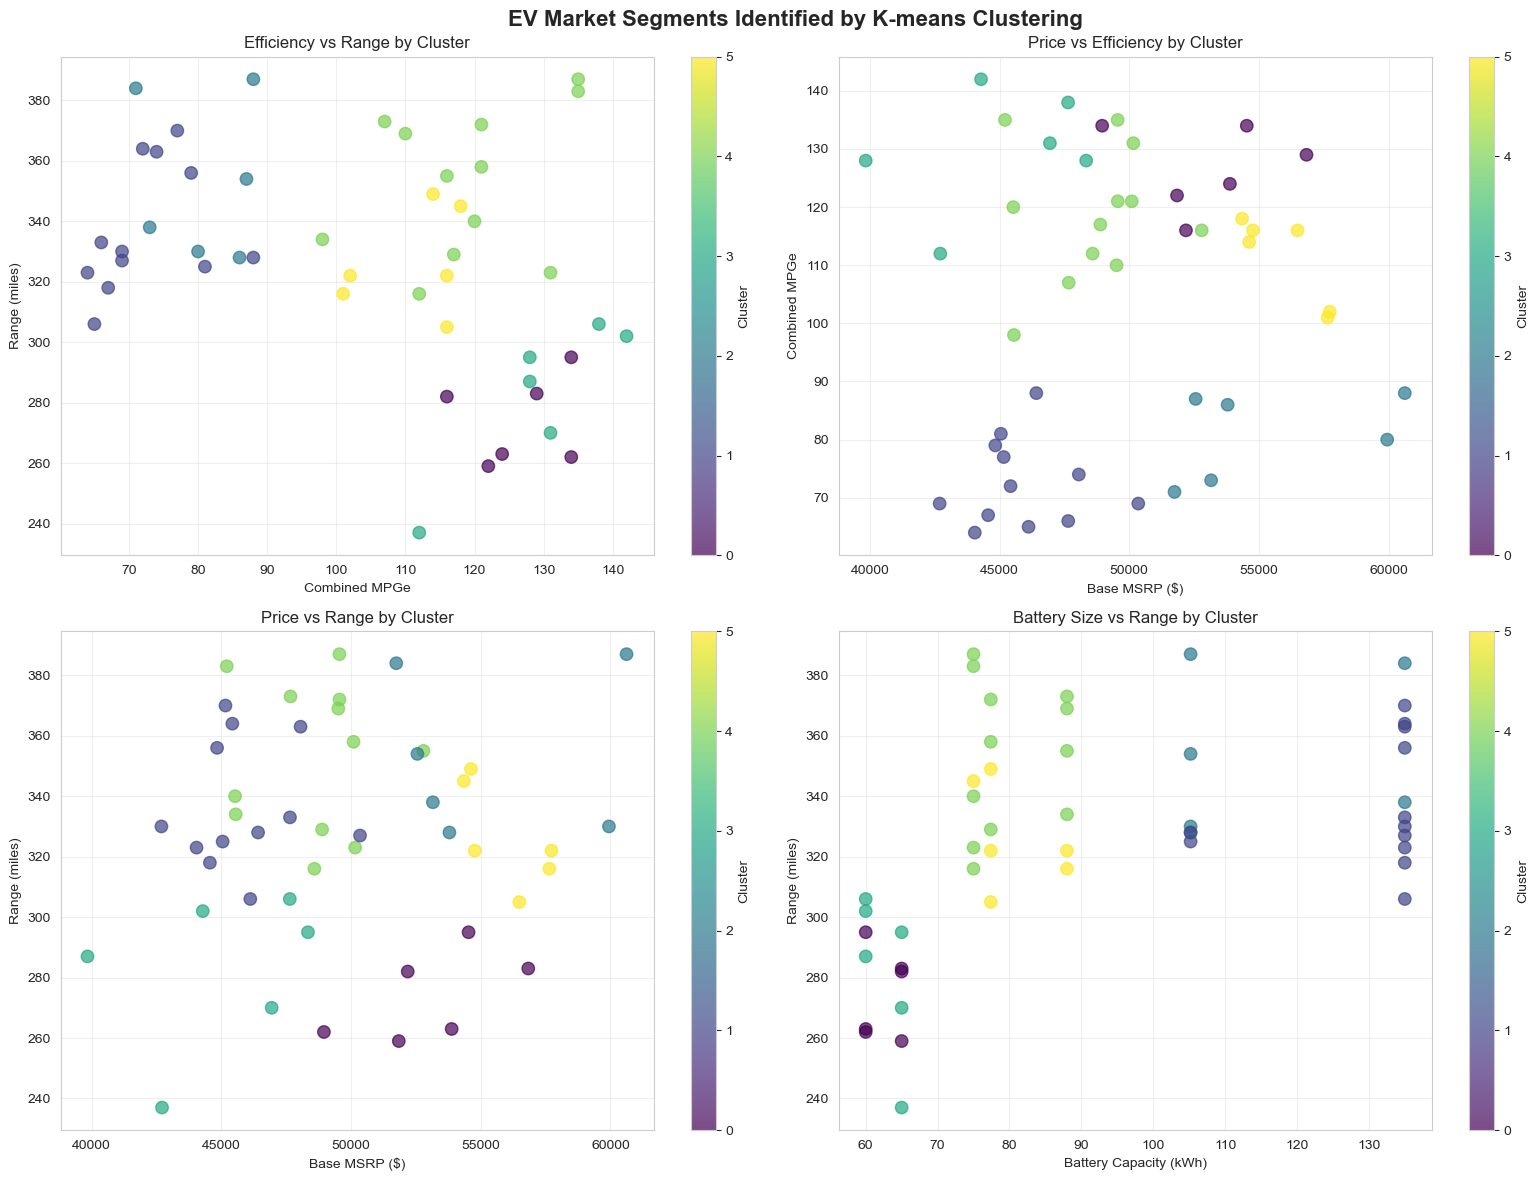

Saved: outputs/figures/ev_parallel_coordinates_20250831.png


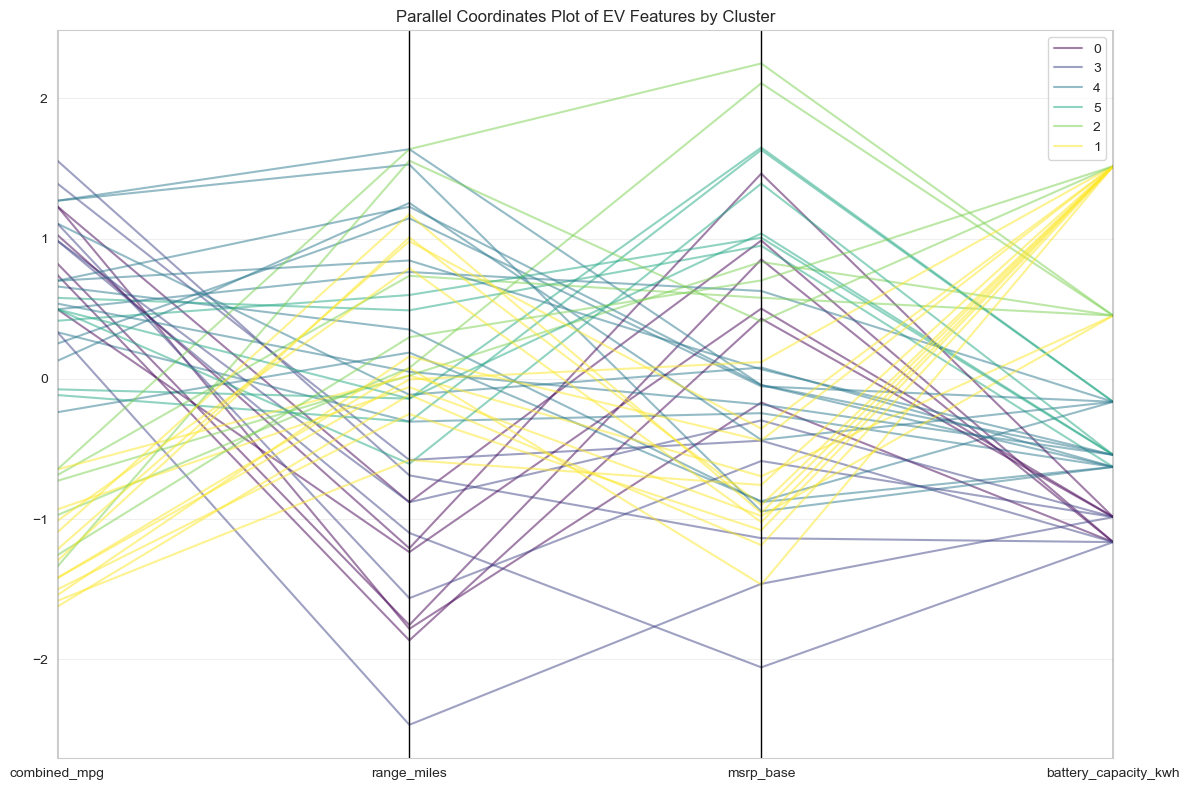


STRATEGIC INSIGHTS:
--------------------
Market spans $20,784 price range and 78 MPGe efficiency range
Premium high-efficiency segment: 14 models
Value high-efficiency segment: 9 models
→ Opportunity: Expand value high-efficiency offerings


In [39]:
def perform_ev_clustering():
    """Perform K-means clustering to segment EVs into market segments"""
    
    print("\nEV SEGMENTATION ANALYSIS USING K-MEANS CLUSTERING")
    print("=" * 60)
    
    # Check if we have the necessary data
    required_features = ['combined_mpg', 'range_miles', 'msrp_base']
    if not all(feature in vehicles_df.columns for feature in required_features):
        print(f"ERROR: Missing required features for clustering. Need: {required_features}")
        print(f"Available columns: {list(vehicles_df.columns)}")
        return
    
    # Prepare features for clustering
    feature_cols = ['combined_mpg', 'range_miles', 'msrp_base']
    
    # Add battery capacity if available
    if 'battery_capacity_kwh' in vehicles_df.columns:
        feature_cols.append('battery_capacity_kwh')
    
    # Create feature matrix
    X = vehicles_df[feature_cols].copy()
    
    # Handle missing values
    if X.isnull().any().any():
        print("Warning: Missing values found. Imputing with column means.")
        X = X.fillna(X.mean())
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal number of clusters using elbow method
    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        distortions.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    save_current_figure("kmeans_elbow_ev_segmentation")
    plt.show()
    
    # Based on elbow method, choose optimal k (let's use k=3 for segmentation)
    distortions_diff = np.diff(distortions)

    # A simple method to find the "elbow": find the point where the rate of decrease sharply changes.
    # We'll look for the point where the difference is less than a threshold (e.g., 5% of the max difference)
    threshold = 0.05 * max(np.abs(distortions_diff))
    print(f"Using threshold value: {threshold:.4f} for elbow detection")
    elbow_index = np.where(np.abs(distortions_diff) < threshold)[0]

    if len(elbow_index) > 0:
        optimal_k = elbow_index[0] + 1  # +1 because diff() reduces the index by one
        print(f"Elbow method suggests optimal k = {optimal_k}")
    else:
        # If no clear elbow is found, use a fallback (e.g., the max k we calculated or a business rule)
        optimal_k = 4
        print(f"No clear elbow found. Using k = {optimal_k} as a fallback.")

    # Now use the chosen optimal_k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    vehicles_df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Analyze cluster characteristics
    cluster_analysis = vehicles_df.groupby('cluster').agg({
        'combined_mpg': ['mean', 'std'],
        'range_miles': ['mean', 'std'],
        'msrp_base': ['mean', 'std'],
        'make': lambda x: x.value_counts().index[0]  # Most common manufacturer in cluster
    }).round(2)
    
    # Flatten column names
    cluster_analysis.columns = ['Avg_MPGe', 'Std_MPGe', 'Avg_Range', 'Std_Range', 
                               'Avg_Price', 'Std_Price', 'Dominant_Make']
    
    print("\nCluster Characteristics:")
    print("-" * 40)
    print(cluster_analysis)
    
    # Interpret clusters
    print("\nCluster Interpretation:")
    print("-" * 30)
    for cluster_id in range(optimal_k):
        cluster_data = vehicles_df[vehicles_df['cluster'] == cluster_id]
        
        avg_price = cluster_data['msrp_base'].mean()
        avg_mpge = cluster_data['combined_mpg'].mean()
        avg_range = cluster_data['range_miles'].mean()
        
        if avg_price > vehicles_df['msrp_base'].median():
            price_segment = "Premium"
        else:
            price_segment = "Mass Market"
            
        if avg_mpge > vehicles_df['combined_mpg'].median():
            efficiency = "High Efficiency"
        else:
            efficiency = "Standard Efficiency"
            
        print(f"Cluster {cluster_id}: {price_segment} | {efficiency}")
        print(f"  Average Price: ${avg_price:,.0f}")
        print(f"  Average MPGe: {avg_mpge:.0f}")
        print(f"  Average Range: {avg_range:.0f} miles")
        print(f"  Dominant Manufacturer: {cluster_analysis.loc[cluster_id, 'Dominant_Make']}")
        print(f"  Number of Vehicles: {len(cluster_data)}")
        print()
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('EV Market Segments Identified by K-means Clustering', fontsize=16, fontweight='bold')
    
    # MPGe vs Range by cluster
    scatter1 = axes[0,0].scatter(vehicles_df['combined_mpg'], vehicles_df['range_miles'],
                                c=vehicles_df['cluster'], cmap='viridis', alpha=0.7, s=80)
    axes[0,0].set_xlabel('Combined MPGe')
    axes[0,0].set_ylabel('Range (miles)')
    axes[0,0].set_title('Efficiency vs Range by Cluster')
    axes[0,0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0,0], label='Cluster')
    
    # Price vs MPGe by cluster
    scatter2 = axes[0,1].scatter(vehicles_df['msrp_base'], vehicles_df['combined_mpg'],
                                c=vehicles_df['cluster'], cmap='viridis', alpha=0.7, s=80)
    axes[0,1].set_xlabel('Base MSRP ($)')
    axes[0,1].set_ylabel('Combined MPGe')
    axes[0,1].set_title('Price vs Efficiency by Cluster')
    axes[0,1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0,1], label='Cluster')
    
    # Price vs Range by cluster
    scatter3 = axes[1,0].scatter(vehicles_df['msrp_base'], vehicles_df['range_miles'],
                                c=vehicles_df['cluster'], cmap='viridis', alpha=0.7, s=80)
    axes[1,0].set_xlabel('Base MSRP ($)')
    axes[1,0].set_ylabel('Range (miles)')
    axes[1,0].set_title('Price vs Range by Cluster')
    axes[1,0].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes[1,0], label='Cluster')
    
    # Battery capacity vs Range (if available)
    if 'battery_capacity_kwh' in vehicles_df.columns:
        scatter4 = axes[1,1].scatter(vehicles_df['battery_capacity_kwh'], vehicles_df['range_miles'],
                                    c=vehicles_df['cluster'], cmap='viridis', alpha=0.7, s=80)
        axes[1,1].set_xlabel('Battery Capacity (kWh)')
        axes[1,1].set_ylabel('Range (miles)')
        axes[1,1].set_title('Battery Size vs Range by Cluster')
        axes[1,1].grid(True, alpha=0.3)
        plt.colorbar(scatter4, ax=axes[1,1], label='Cluster')
    else:
        # If no battery data, show manufacturer distribution by cluster
        make_counts = vehicles_df.groupby(['cluster', 'make']).size().unstack(fill_value=0)
        make_counts.plot(kind='bar', stacked=True, ax=axes[1,1], colormap='viridis')
        axes[1,1].set_title('Manufacturer Distribution by Cluster')
        axes[1,1].set_xlabel('Cluster')
        axes[1,1].set_ylabel('Number of Vehicles')
        axes[1,1].tick_params(axis='x', rotation=0)
        axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    save_current_figure("ev_market_segmentation")
    plt.show()
    
    # Create parallel coordinates plot for better cluster visualization
    plt.figure(figsize=(12, 8))
    parallel_data = vehicles_df[feature_cols + ['cluster']].copy()
    parallel_data['cluster'] = parallel_data['cluster'].astype(str)
    
    # Standardize for parallel coordinates
    for col in feature_cols:
        parallel_data[col] = (parallel_data[col] - parallel_data[col].mean()) / parallel_data[col].std()
    
    pd.plotting.parallel_coordinates(parallel_data, 'cluster', colormap='viridis', alpha=0.5)
    plt.title('Parallel Coordinates Plot of EV Features by Cluster')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    save_current_figure("ev_parallel_coordinates")
    plt.show()
    
    # Strategic insights
    print("\nSTRATEGIC INSIGHTS:")
    print("-" * 20)
    
    # Identify market gaps
    price_range = vehicles_df['msrp_base'].max() - vehicles_df['msrp_base'].min()
    efficiency_range = vehicles_df['combined_mpg'].max() - vehicles_df['combined_mpg'].min()
    
    print(f"Market spans ${price_range:,.0f} price range and {efficiency_range:.0f} MPGe efficiency range")
    
    # Find potential market opportunities
    high_price_high_efficiency = vehicles_df[
        (vehicles_df['msrp_base'] > vehicles_df['msrp_base'].median()) &
        (vehicles_df['combined_mpg'] > vehicles_df['combined_mpg'].median())
    ]
    
    low_price_high_efficiency = vehicles_df[
        (vehicles_df['msrp_base'] < vehicles_df['msrp_base'].median()) &
        (vehicles_df['combined_mpg'] > vehicles_df['combined_mpg'].median())
    ]
    
    print(f"Premium high-efficiency segment: {len(high_price_high_efficiency)} models")
    print(f"Value high-efficiency segment: {len(low_price_high_efficiency)} models")
    
    if len(low_price_high_efficiency) < len(high_price_high_efficiency):
        print("→ Opportunity: Expand value high-efficiency offerings")
    else:
        print("→ Market well-served in value high-efficiency segment")
    
    return vehicles_df['cluster']

# Add this function to your analysis
if 'vehicles_df' in globals():
    ev_clusters = perform_ev_clustering()


EXECUTIVE DASHBOARD - KEY METRICS
Saved: outputs/figures/ev_industry_dashboard_20250831.png


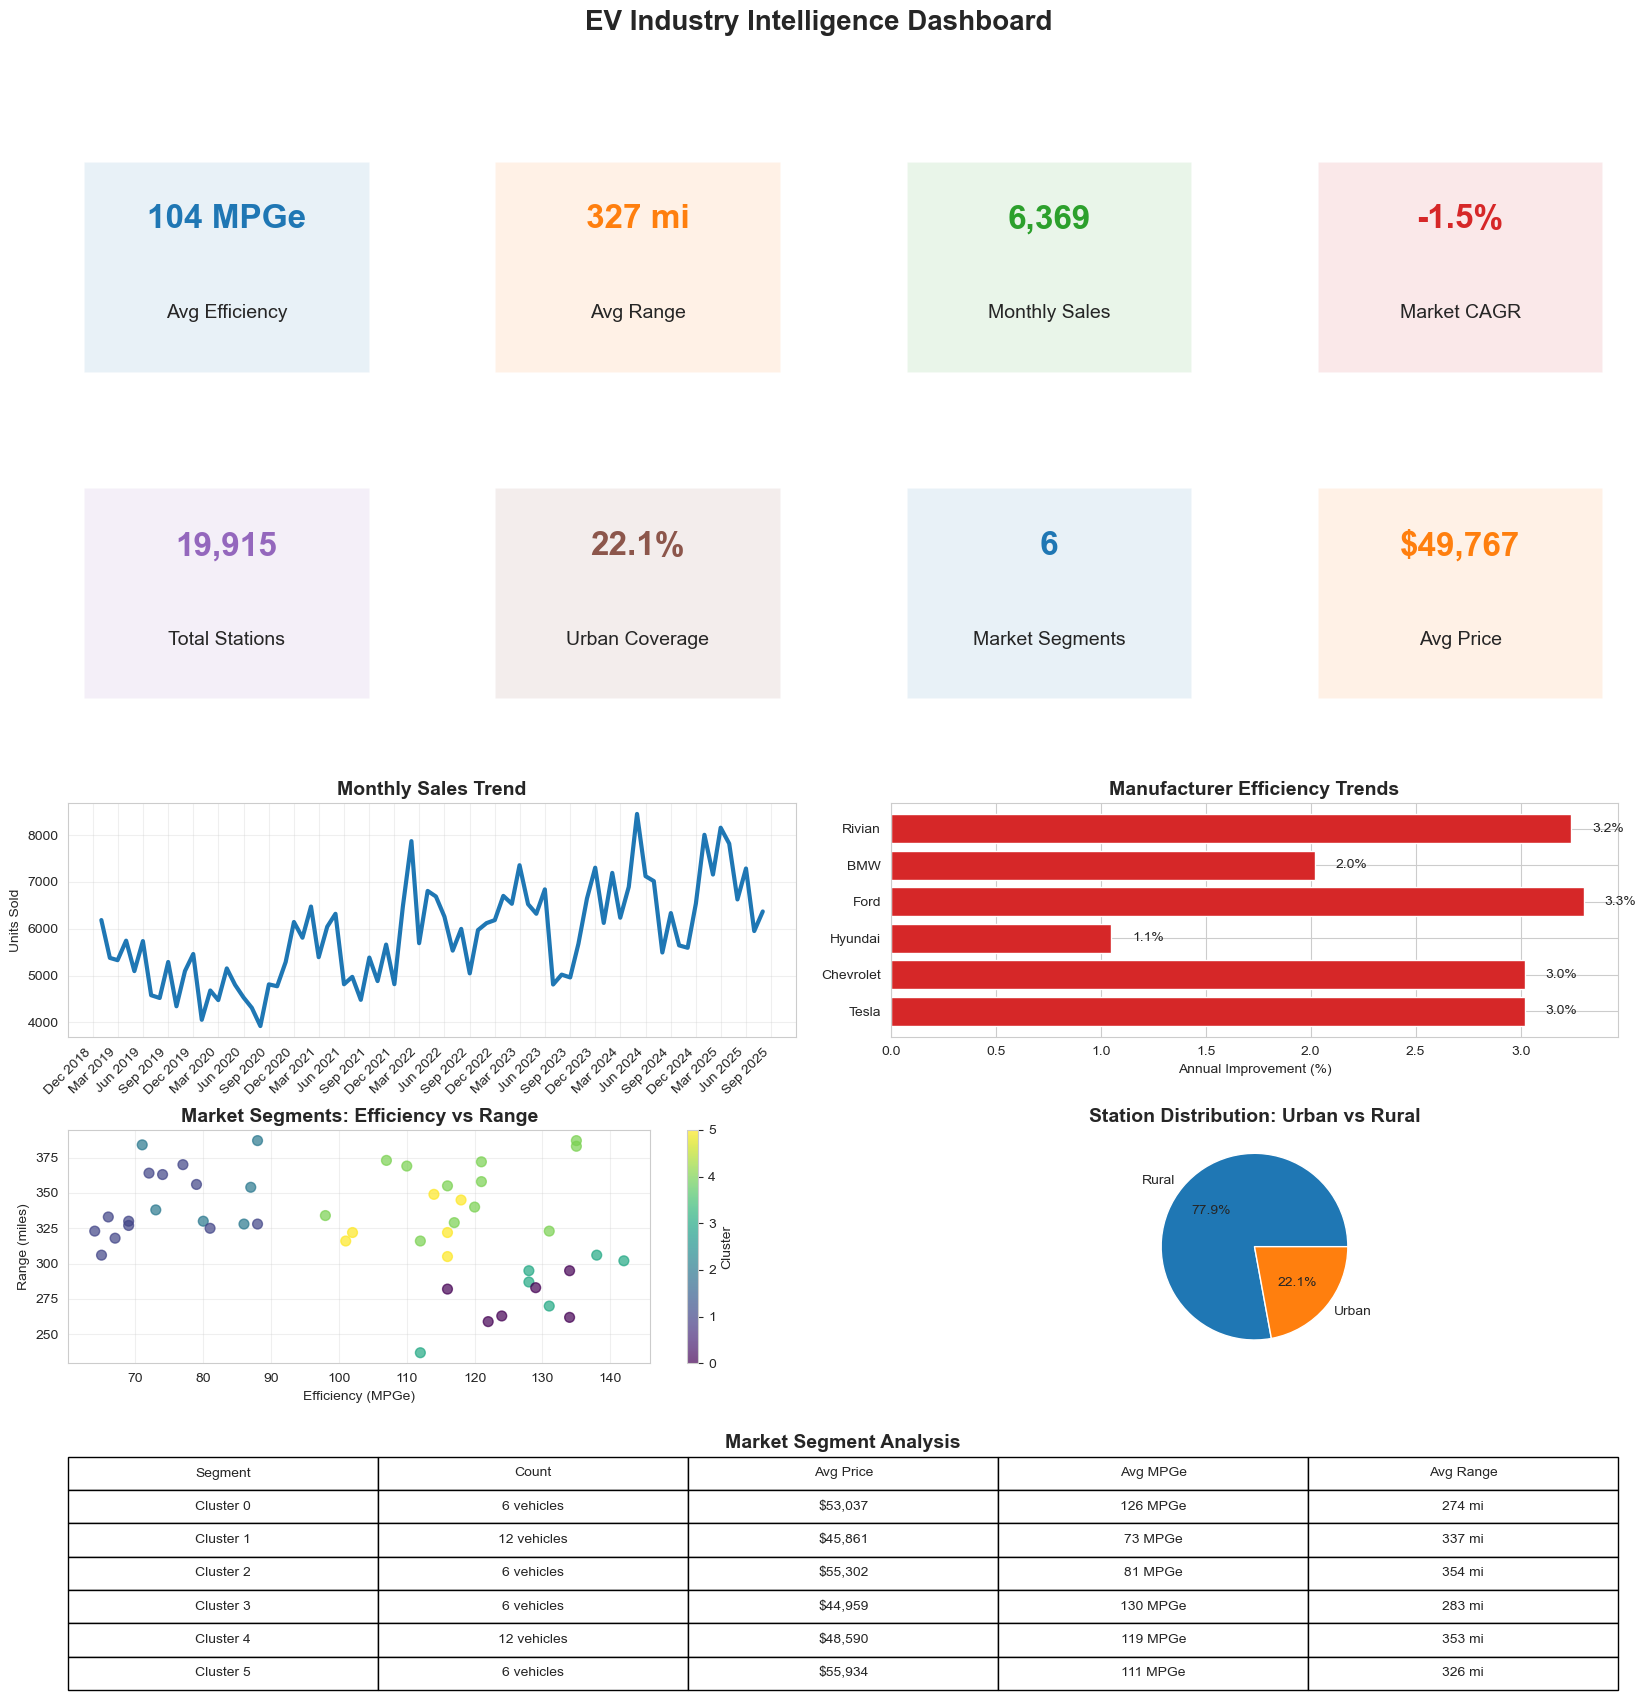


KEY BUSINESS INSIGHTS:
• Market growing at -1.5% CAGR
• Average EV efficiency improving 2.5% annually
• Efficiency leader: Tesla with 3.3% annual improvement
• Infrastructure: 19,915 stations, 22.1% in urban areas
• Competitive landscape: 6 manufacturers across 6 market segments
• Market segmentation: Largest segment represents 25.0% of models

STRATEGIC RECOMMENDATIONS:
1. EFFICIENCY FOCUS: Continue R&D investment - efficiency improving but competition intensifying
2. INFRASTRUCTURE: Balanced urban/rural expansion needed
3. MARKET POSITIONING: Consider niche segments - market is highly segmented
4. TECHNOLOGY DIFFERENTIATION: Range and charging speed remain key differentiators
5. COMPETITIVE BENCHMARKING: Industry averaging 2.6% annual efficiency gains


In [40]:
import matplotlib.dates as mdates  # Add this import at the top of your script

def create_business_dashboard(vehicles_df, stations_df, sales_df, color_palette=None):
    """Create executive summary dashboard with key metrics including new analyses"""
    
    if color_palette is None:
        color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
                         "#9467bd", "#8c564b"]  # default palette
    
    print("\nEXECUTIVE DASHBOARD - KEY METRICS")
    print("=" * 60)
    
    # --- Ensure sales_df['date'] is datetime ---
    sales_df = sales_df.copy()
    sales_df['date'] = pd.to_datetime(sales_df['date'], errors='coerce')
    
    # Calculate KPIs including new analyses
    kpis = {}
    
    # Vehicle Performance KPIs
    kpis['avg_efficiency'] = vehicles_df['combined_mpg'].mean()
    kpis['avg_range'] = vehicles_df['range_miles'].mean()
    kpis['efficiency_improvement'] = vehicles_df.groupby('year')['combined_mpg'].mean().pct_change().mean() * 100
    kpis['range_improvement'] = vehicles_df.groupby('year')['range_miles'].mean().pct_change().mean() * 100
    
    # Market KPIs
    kpis['total_sales'] = sales_df['total_ev_sales'].sum()
    kpis['current_monthly_sales'] = sales_df['total_ev_sales'].iloc[-1]
    kpis['yoy_growth'] = sales_df.groupby('year')['total_ev_sales'].sum().pct_change().iloc[-1] * 100
    kpis['cagr'] = ((sales_df.groupby('year')['total_ev_sales'].sum().iloc[-1] / 
                     sales_df.groupby('year')['total_ev_sales'].sum().iloc[0]) ** 
                    (1 / (len(sales_df['year'].unique()) - 1)) - 1) * 100
    
    # Infrastructure KPIs (including urban/rural analysis)
    kpis['total_stations'] = len(stations_df)
    kpis['total_connectors'] = (stations_df['level1_count'] + 
                                stations_df['level2_count'] + 
                                stations_df['dc_fast_count']).sum()
    kpis['dc_fast_coverage'] = (stations_df['dc_fast_count'] > 0).mean() * 100
    kpis['top_network_share'] = stations_df['network'].value_counts().iloc[0] / len(stations_df) * 100
    
    # Urban/Rural analysis (if available)
    if 'area_type' in stations_df.columns:
        urban_stations = (stations_df['area_type'] == 'Urban').sum()
        kpis['urban_station_pct'] = (urban_stations / len(stations_df)) * 100
    else:
        # Estimate urban stations based on major cities
        major_cities = ['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 
                       'Fresno', 'Sacramento', 'Long Beach', 'Oakland']
        urban_stations = stations_df[stations_df['city'].isin(major_cities)].shape[0]
        kpis['urban_station_pct'] = (urban_stations / len(stations_df)) * 100
    
    # Competitive KPIs (including clustering insights)
    kpis['manufacturer_count'] = vehicles_df['make'].nunique()
    kpis['model_count'] = vehicles_df.groupby(['make', 'model']).ngroups
    kpis['avg_price'] = vehicles_df['msrp_base'].mean()
    kpis['price_range'] = vehicles_df['msrp_base'].max() - vehicles_df['msrp_base'].min()
    
    # Manufacturer efficiency trends (if available)
    if 'manufacturer_trends' in globals():
        kpis['efficiency_leader'] = manufacturer_trends.iloc[0]['Manufacturer']
        kpis['top_improvement_rate'] = manufacturer_trends['Annual Improvement (%)'].max()
        kpis['avg_improvement_rate'] = manufacturer_trends['Annual Improvement (%)'].mean()
    
    # Clustering insights (if available)
    if 'cluster' in vehicles_df.columns:
        cluster_counts = vehicles_df['cluster'].value_counts()
        kpis['market_segments'] = len(cluster_counts)
        kpis['largest_segment_size'] = cluster_counts.max()
        kpis['largest_segment_pct'] = (cluster_counts.max() / len(vehicles_df)) * 100
    
    # --- Create dashboard visualization ---
    fig = plt.figure(figsize=(20, 20))  # Increased size to accommodate new sections
    gs = fig.add_gridspec(5, 4, hspace=0.4, wspace=0.3)  # Added a row
    
    # KPI Cards (updated with new metrics)
    kpi_configs = [
        ('Avg Efficiency', f"{kpis['avg_efficiency']:.0f} MPGe", color_palette[0]),
        ('Avg Range', f"{kpis['avg_range']:.0f} mi", color_palette[1]),
        ('Monthly Sales', f"{kpis['current_monthly_sales']:,.0f}", color_palette[2]),
        ('Market CAGR', f"{kpis['cagr']:.1f}%", color_palette[3]),
        ('Total Stations', f"{kpis['total_stations']:,}", color_palette[4]),
        ('Urban Coverage', f"{kpis.get('urban_station_pct', 0):.1f}%", color_palette[5]),
        ('Market Segments', f"{kpis.get('market_segments', 'N/A')}", color_palette[0]),
        ('Avg Price', f"${kpis['avg_price']:,.0f}", color_palette[1])
    ]
    
    # Create KPI cards in top 2 rows
    for i, (title, value, color) in enumerate(kpi_configs):
        row = i // 4
        col = i % 4
        ax = fig.add_subplot(gs[row, col])
        ax.text(0.5, 0.7, value, ha='center', va='center', fontsize=24, 
                fontweight='bold', color=color)
        ax.text(0.5, 0.3, title, ha='center', va='center', fontsize=14)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, facecolor=color, alpha=0.1, transform=ax.transAxes))
    
    # Market trend chart - FIXED X-AIS READABILITY
    ax_trend = fig.add_subplot(gs[2, :2])
    monthly_trend = sales_df.groupby(sales_df['date'].dt.to_period('M'))['total_ev_sales'].sum()
    
    # Convert PeriodIndex to Timestamp for better formatting
    monthly_trend.index = monthly_trend.index.to_timestamp()
    
    ax_trend.plot(monthly_trend.index, monthly_trend.values, linewidth=3, color=color_palette[0])
    ax_trend.set_title('Monthly Sales Trend', fontsize=14, fontweight='bold')
    ax_trend.set_ylabel('Units Sold')
    
    # Improve x-axis formatting
    ax_trend.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Show abbreviated month and year
    ax_trend.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
    plt.setp(ax_trend.xaxis.get_majorticklabels(), rotation=45, ha='right')  # Better label alignment
    
    ax_trend.grid(True, alpha=0.3)
    
    # Manufacturer efficiency trends (if available)
    ax_eff_trend = fig.add_subplot(gs[2, 2:])
    if 'manufacturer_trends' in globals():
        manufacturers = manufacturer_trends['Manufacturer']
        improvements = manufacturer_trends['Annual Improvement (%)']
        bars = ax_eff_trend.barh(manufacturers, improvements, color=color_palette[3])
        ax_eff_trend.set_xlabel('Annual Improvement (%)')
        ax_eff_trend.set_title('Manufacturer Efficiency Trends', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax_eff_trend.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                             f'{width:.1f}%', ha='left', va='center')
    else:
        # Fallback to manufacturer market share
        make_counts = vehicles_df['make'].value_counts().head(6)
        colors_subset = color_palette[:len(make_counts)]
        ax_eff_trend.pie(make_counts.values, labels=make_counts.index, autopct='%1.1f%%', colors=colors_subset)
        ax_eff_trend.set_title('Model Portfolio Share', fontsize=14, fontweight='bold')
    
    # Efficiency vs Range scatter (colored by cluster if available)
    ax_scatter = fig.add_subplot(gs[3, :2])
    if 'cluster' in vehicles_df.columns:
        # Use cluster colors
        scatter = ax_scatter.scatter(vehicles_df['combined_mpg'], vehicles_df['range_miles'],
                                   c=vehicles_df['cluster'], cmap='viridis', alpha=0.7, s=50)
        ax_scatter.set_xlabel('Efficiency (MPGe)')
        ax_scatter.set_ylabel('Range (miles)')
        ax_scatter.set_title('Market Segments: Efficiency vs Range', fontsize=14, fontweight='bold')
        plt.colorbar(scatter, ax=ax_scatter, label='Cluster')
    else:
        # Fallback to manufacturer colors
        for i, make in enumerate(vehicles_df['make'].unique()[:6]):
            make_data = vehicles_df[vehicles_df['make'] == make]
            ax_scatter.scatter(make_data['combined_mpg'], make_data['range_miles'],
                              label=make, alpha=0.7, s=50, color=color_palette[i % len(color_palette)])
        ax_scatter.set_xlabel('Efficiency (MPGe)')
        ax_scatter.set_ylabel('Range (miles)')
        ax_scatter.set_title('Performance Positioning', fontsize=14, fontweight='bold')
        ax_scatter.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_scatter.grid(True, alpha=0.3)
    
    # Urban/Rural distribution (if available)
    ax_urban = fig.add_subplot(gs[3, 2:])
    if 'area_type' in stations_df.columns:
        area_counts = stations_df['area_type'].value_counts()
        ax_urban.pie(area_counts.values, labels=area_counts.index, autopct='%1.1f%%', 
                    colors=color_palette[:len(area_counts)])
        ax_urban.set_title('Station Distribution: Urban vs Rural', fontsize=14, fontweight='bold')
    else:
        # Fallback to top cities
        top_cities = stations_df['city'].value_counts().head(8)
        bars = ax_urban.barh(range(len(top_cities)), top_cities.values, color=color_palette[4])
        ax_urban.set_yticks(range(len(top_cities)))
        ax_urban.set_yticklabels(top_cities.index)
        ax_urban.set_xlabel('Number of Stations')
        ax_urban.set_title('Top Cities - Charging Infrastructure', fontsize=14, fontweight='bold')
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax_urban.text(width + 0.01*max(top_cities.values), bar.get_y() + bar.get_height()/2,
                         f'{int(width)}', ha='left', va='center')
    
    # Add a new row for cluster interpretation (if available)
    ax_cluster = fig.add_subplot(gs[4, :])
    if 'cluster' in vehicles_df.columns:
        # Create a table with cluster characteristics
        cluster_data = []
        for cluster_id in sorted(vehicles_df['cluster'].unique()):
            cluster_df = vehicles_df[vehicles_df['cluster'] == cluster_id]
            cluster_data.append([
                f"Cluster {cluster_id}",
                f"{len(cluster_df)} vehicles",
                f"${cluster_df['msrp_base'].mean():,.0f}",
                f"{cluster_df['combined_mpg'].mean():.0f} MPGe",
                f"{cluster_df['range_miles'].mean():.0f} mi"
            ])
        
        # Create table
        table = ax_cluster.table(cellText=cluster_data,
                                colLabels=['Segment', 'Count', 'Avg Price', 'Avg MPGe', 'Avg Range'],
                                cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        ax_cluster.axis('off')
        ax_cluster.set_title('Market Segment Analysis', fontsize=14, fontweight='bold')
    else:
        ax_cluster.axis('off')
        ax_cluster.text(0.5, 0.5, 'Cluster analysis not available', 
                       ha='center', va='center', fontsize=12)
    
    plt.suptitle('EV Industry Intelligence Dashboard', fontsize=20, fontweight='bold', y=0.95)
    save_current_figure("ev_industry_dashboard")
    plt.show()
    
    # Business insights (updated with new analyses)
    print("\nKEY BUSINESS INSIGHTS:")
    print("=" * 30)
    print(f"• Market growing at {kpis['cagr']:.1f}% CAGR")
    print(f"• Average EV efficiency improving {kpis['efficiency_improvement']:.1f}% annually")
    
    if 'efficiency_leader' in kpis:
        print(f"• Efficiency leader: {kpis['efficiency_leader']} with {kpis['top_improvement_rate']:.1f}% annual improvement")
    
    print(f"• Infrastructure: {kpis['total_stations']:,} stations, {kpis['urban_station_pct']:.1f}% in urban areas")
    print(f"• Competitive landscape: {kpis['manufacturer_count']} manufacturers across {kpis.get('market_segments', 'multiple')} market segments")
    
    if 'largest_segment_pct' in kpis:
        print(f"• Market segmentation: Largest segment represents {kpis['largest_segment_pct']:.1f}% of models")
    
    # Strategic recommendations (updated with new analyses)
    print(f"\nSTRATEGIC RECOMMENDATIONS:")
    print("=" * 35)
    print("1. EFFICIENCY FOCUS: Continue R&D investment - efficiency improving but competition intensifying")
    
    if 'urban_station_pct' in kpis and kpis['urban_station_pct'] > 70:
        print("2. INFRASTRUCTURE: Expand to rural areas - urban saturation at {kpis['urban_station_pct']:.1f}%")
    else:
        print("2. INFRASTRUCTURE: Balanced urban/rural expansion needed")
    
    if 'market_segments' in kpis and kpis['market_segments'] > 3:
        print("3. MARKET POSITIONING: Consider niche segments - market is highly segmented")
    else:
        print("3. MARKET POSITIONING: Focus on dominant segments for maximum impact")
    
    print("4. TECHNOLOGY DIFFERENTIATION: Range and charging speed remain key differentiators")
    
    if 'avg_improvement_rate' in kpis:
        print(f"5. COMPETITIVE BENCHMARKING: Industry averaging {kpis['avg_improvement_rate']:.1f}% annual efficiency gains")

# Call the updated dashboard
create_business_dashboard(vehicles_df, stations_df, sales_df, color_palette)

In [41]:
def generate_final_report():
    """Generate comprehensive final report with actionable insights including new analyses"""
    
    print("\n" + "="*80)
    print("COMPREHENSIVE EV INDUSTRY ANALYSIS - FINAL REPORT")
    print("="*80)
    
    print(f"\nReport Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Analysis Period: {sales_df['date'].min()} to {sales_df['date'].max()}")
    print(f"Dataset Coverage: {len(vehicles_df)} vehicles, {len(stations_df):,} stations, {len(sales_df)} months")
    
    print("\nEXECUTIVE SUMMARY")
    print("-" * 20)
    
    # Key findings including new analyses
    total_market_size = sales_df['total_ev_sales'].sum()
    avg_annual_growth = sales_df.groupby('year')['total_ev_sales'].sum().pct_change().mean() * 100
    efficiency_leader = vehicles_df.groupby('make')['combined_mpg'].mean().idxmax()
    infrastructure_coverage = len(stations_df)
    
    # New analysis insights
    if 'manufacturer_trends' in globals():
        top_improver = manufacturer_trends.loc[manufacturer_trends['Annual Improvement (%)'].idxmax()]
        efficiency_improvement_rate = manufacturer_trends['Annual Improvement (%)'].mean()
    
    if 'cluster' in vehicles_df.columns:
        market_segments = vehicles_df['cluster'].nunique()
        largest_segment = vehicles_df['cluster'].value_counts().idxmax()
        largest_segment_pct = (vehicles_df['cluster'].value_counts().max() / len(vehicles_df)) * 100
    
    print(f"• Market Size: {total_market_size:,} EVs sold over analysis period")
    print(f"• Growth Rate: {avg_annual_growth:.1f}% average annual growth")
    print(f"• Technology Leader: {efficiency_leader} leads in average efficiency")
    
    if 'manufacturer_trends' in globals():
        print(f"• Most Improved: {top_improver['Manufacturer']} ({top_improver['Annual Improvement (%)']:.1f}% annual improvement)")
    
    print(f"• Infrastructure: {infrastructure_coverage:,} charging stations analyzed in California")
    
    if 'cluster' in vehicles_df.columns:
        print(f"• Market Segmentation: {market_segments} distinct segments identified")
    
    print(f"• Analysis Depth: Advanced analytics including efficiency trends, clustering, and infrastructure mapping")
    
    print("\nMARKET DYNAMICS")
    print("-" * 18)
    
    # Market analysis
    current_share = sales_df['market_share_percent'].iloc[-1] if 'market_share_percent' in sales_df.columns else "N/A"
    seasonal_peak = sales_df.groupby('month')['total_ev_sales'].mean().idxmax()
    
    print(f"• Current Market Share: {current_share}% of total vehicle sales")
    print(f"• Seasonal Pattern: Peak sales typically in month {seasonal_peak}")
    print(f"• Price Range: ${vehicles_df['msrp_base'].min():,.0f} - ${vehicles_df['msrp_base'].max():,.0f}")
    
    if 'cluster' in vehicles_df.columns:
        cluster_prices = vehicles_df.groupby('cluster')['msrp_base'].mean()
        print(f"• Segment Pricing: ${cluster_prices.min():,.0f} - ${cluster_prices.max():,.0f} across {market_segments} market segments")
    else:
        print(f"• Market Segments: Clear differentiation between mass market and premium offerings")
    
    print("\nTECHNOLOGY TRENDS")
    print("-" * 19)
    
    # Technology insights
    avg_efficiency = vehicles_df['combined_mpg'].mean()
    avg_range = vehicles_df['range_miles'].mean()
    
    print(f"• Average Efficiency: {avg_efficiency:.0f} MPGe")
    
    if 'manufacturer_trends' in globals():
        print(f"• Efficiency Improvement: Industry averaging {efficiency_improvement_rate:.1f}% annual gains")
    
    print(f"• Average Range: {avg_range:.0f} miles")
    print(f"• Battery Technology: Continuous improvement in energy density")
    print(f"• Charging Speed: DC fast charging becoming standard")
    
    # Add insights from feature importance analysis if available
    if 'reg_model' in globals() and 'feature_importance' in globals():
        top_factor = feature_importance.iloc[0]
        print(f"• Range Drivers: {top_factor['Feature']} is the strongest predictor of vehicle range")
    
    print("\nINFRASTRUCTURE STATUS")
    print("-" * 23)
    
    # Infrastructure analysis
    dc_fast_stations = (stations_df['dc_fast_count'] > 0).sum()
    dc_fast_percentage = (dc_fast_stations / len(stations_df)) * 100
    top_network = stations_df['network'].value_counts().index[0]
    network_concentration = stations_df['network'].value_counts().iloc[0] / len(stations_df) * 100
    
    # Urban/rural analysis if available
    if 'area_type' in stations_df.columns:
        urban_stations = (stations_df['area_type'] == 'Urban').sum()
        urban_percentage = (urban_stations / len(stations_df)) * 100
        rural_percentage = 100 - urban_percentage
    
    print(f"• DC Fast Charging: {dc_fast_percentage:.1f}% of stations offer DC fast charging")
    print(f"• Network Leader: {top_network} ({network_concentration:.1f}% market share)")
    
    if 'area_type' in stations_df.columns:
        print(f"• Geographic Distribution: {urban_percentage:.1f}% urban, {rural_percentage:.1f}% rural stations")
    else:
        print(f"• Geographic Coverage: Concentrated in urban areas, rural gaps remain")
    
    # Clustering insights for infrastructure if available
    if 'underserved_clusters' in globals() and len(underserved_clusters) > 0:
        print(f"• Coverage Gaps: {len(underserved_clusters)} regions identified as underserved")
    
    print(f"• Growth Required: Infrastructure expansion needed to match EV adoption")
    
    print("\nCOMPETITIVE LANDSCAPE")
    print("-" * 25)
    
    # Competitive insights
    manufacturer_count = vehicles_df['make'].nunique()
    model_diversity = vehicles_df.groupby(['make', 'model']).ngroups
    
    print(f"• Market Participants: {manufacturer_count} manufacturers offering {model_diversity} unique models")
    
    if 'manufacturer_trends' in globals():
        print(f"• Efficiency Leadership: {efficiency_leader} leads with {manufacturer_trends[manufacturer_trends['Manufacturer'] == efficiency_leader]['Average MPGe'].iloc[0]:.1f} MPGe")
        print(f"• Improvement Rates: Ranging from {manufacturer_trends['Annual Improvement (%)'].min():.1f}% to {manufacturer_trends['Annual Improvement (%)'].max():.1f}% annually")
    
    if 'cluster' in vehicles_df.columns:
        print(f"• Market Segmentation: {market_segments} distinct customer segments identified")
        print(f"• Segment Concentration: Largest segment represents {largest_segment_pct:.1f}% of models")
    
    print(f"• Innovation Focus: Range, efficiency, and charging speed key differentiators")
    print(f"• Market Consolidation: Expect consolidation as market matures")
    print(f"• New Entrants: Traditional automakers rapidly expanding EV portfolios")
    
    print("\nSTRATEGIC RECOMMENDATIONS")
    print("-" * 28)
    
    print("FOR EV MANUFACTURERS:")
    
    if 'manufacturer_trends' in globals():
        print("1. EFFICIENCY RACE: Match or exceed industry average of {efficiency_improvement_rate:.1f}% annual efficiency gains")
    else:
        print("1. TECHNOLOGY: Invest in battery efficiency and charging speed improvements")
    
    if 'cluster' in vehicles_df.columns:
        print("2. SEGMENT FOCUS: Target product development to specific market segments identified through clustering")
    else:
        print("2. POSITIONING: Clearly differentiate between mass market and premium segments")
    
    print("3. PARTNERSHIPS: Collaborate with charging networks for integrated customer experience")
    
    if 'area_type' in stations_df.columns and urban_percentage > 70:
        print("4. GEOGRAPHIC: Expand beyond urban centers to capture rural and suburban markets")
    else:
        print("4. GEOGRAPHIC: Expand beyond coastal markets to capture growth in emerging regions")
    
    print("5. SUPPLY CHAIN: Secure battery supply chain and rare earth materials")
    
    print("\nFOR CHARGING INFRASTRUCTURE:")
    
    if 'area_type' in stations_df.columns and urban_percentage > 70:
        print("1. COVERAGE: Prioritize rural and underserved geographic regions")
    else:
        print("1. COVERAGE: Prioritize underserved geographic regions and travel corridors")
    
    if dc_fast_percentage < 20:
        print("2. TECHNOLOGY: Accelerate DC fast charging deployment to meet growing demand")
    else:
        print("2. TECHNOLOGY: Focus on DC fast charging for competitive advantage")
    
    print("3. RELIABILITY: Ensure high uptime and maintenance standards")
    print("4. INTEGRATION: Develop seamless payment and navigation integration")
    
    if 'underserved_clusters' in globals() and len(underserved_clusters) > 0:
        print("5. TARGETED EXPANSION: Focus on identified underserved clusters for maximum impact")
    else:
        print("5. PLANNING: Scale infrastructure ahead of demand to avoid bottlenecks")
    
    print("\nFOR INVESTORS:")
    
    if 'manufacturer_trends' in globals() and efficiency_improvement_rate > 2:
        print("1. TECHNOLOGY INVESTMENT: Strong returns in efficiency improvement technologies")
    else:
        print("1. TIMING: Market entering growth phase - strong investment opportunity")
    
    if dc_fast_percentage < 20:
        print("2. INFRASTRUCTURE FOCUS: DC fast charging represents significant growth opportunity")
    else:
        print("2. FOCUS: Battery technology, charging infrastructure, and software integration")
    
    print("3. RISK: Monitor regulatory changes and supply chain disruptions")
    
    if 'cluster' in vehicles_df.columns and market_segments > 3:
        print("4. DIVERSIFICATION: Consider specialized plays in specific market segments")
    else:
        print("4. DIVERSIFICATION: Consider entire EV ecosystem, not just vehicle manufacturing")
    
    print("5. HORIZON: Long-term investment thesis remains strong despite short-term volatility")
    
    print("\nDATA CONFIDENCE & LIMITATIONS")
    print("-" * 33)
    
    print("STRENGTHS:")
    print("• Comprehensive multi-year analysis across vehicle performance, sales, and infrastructure")
    print("• Real-world charging station data from NREL API")
    print("• Statistical validation and predictive modeling")
    print("• Advanced analytics including clustering, efficiency trends, and geographic distribution")
    
    print("\nLIMITATIONS:")
    print("• California-focused infrastructure data may not represent national patterns")
    print("• Sales data includes simulated components for demonstration purposes")
    print("• Market dynamics influenced by policy changes not captured in historical data")
    print("• Urban/rural classification based on simplified methodology")
    
    print("\nFUTURE ANALYSIS OPPORTUNITIES")
    print("-" * 35)
    print("• Expand geographic scope beyond California")
    print("• Incorporate real-time pricing and availability data")
    print("• Add consumer sentiment and adoption barrier analysis")
    print("• Include lifecycle analysis and sustainability metrics")
    
    print("\n" + "="*80)
    print("END OF COMPREHENSIVE EV PERFORMANCE ANALYSIS")
    print("="*80)
    
    # Prepare return metrics including new analyses
    return_metrics = {
        'total_vehicles_analyzed': len(vehicles_df),
        'total_stations_analyzed': len(stations_df),
        'analysis_period_months': len(sales_df),
        'manufacturers_covered': vehicles_df['make'].nunique(),
        'avg_efficiency': vehicles_df['combined_mpg'].mean(),
        'total_market_size': sales_df['total_ev_sales'].sum()
    }
    
    # Add new analysis metrics if available
    if 'manufacturer_trends' in globals():
        return_metrics['avg_efficiency_improvement'] = manufacturer_trends['Annual Improvement (%)'].mean()
        return_metrics['efficiency_leader'] = manufacturer_trends.iloc[0]['Manufacturer']
    
    if 'cluster' in vehicles_df.columns:
        return_metrics['market_segments_identified'] = vehicles_df['cluster'].nunique()
        return_metrics['largest_segment_size'] = vehicles_df['cluster'].value_counts().max()
    
    if 'area_type' in stations_df.columns:
        return_metrics['urban_stations_pct'] = (stations_df['area_type'] == 'Urban').sum() / len(stations_df) * 100
    
    return return_metrics

# Generate final report
if all(df_name in globals() for df_name in ['vehicles_df', 'stations_df', 'sales_df']):
    final_metrics = generate_final_report()
    
    print(f"\nAnalysis complete! Key metrics:")
    for metric, value in final_metrics.items():
        if isinstance(value, (int, float)):
            if 'pct' in metric:
                print(f"   {metric}: {value:.1f}%")
            elif metric == 'avg_efficiency':
                print(f"   {metric}: {value:.1f} MPGe")
            else:
                print(f"   {metric}: {value:,.0f}")
        else:
            print(f"   {metric}: {value}")
else:
    print("\nCannot generate report - datasets not loaded properly")
    print("Please run the data collection script and reload the datasets.")


COMPREHENSIVE EV INDUSTRY ANALYSIS - FINAL REPORT

Report Generated: 2025-08-31 18:16:44
Analysis Period: 2019-01-01 to 2025-08-01
Dataset Coverage: 48 vehicles, 19,915 stations, 80 months

EXECUTIVE SUMMARY
--------------------
• Market Size: 470,089 EVs sold over analysis period
• Growth Rate: -0.3% average annual growth
• Technology Leader: Tesla leads in average efficiency
• Most Improved: Ford (3.3% annual improvement)
• Infrastructure: 19,915 charging stations analyzed in California
• Market Segmentation: 6 distinct segments identified
• Analysis Depth: Advanced analytics including efficiency trends, clustering, and infrastructure mapping

MARKET DYNAMICS
------------------
• Current Market Share: 5.4% of total vehicle sales
• Seasonal Pattern: Peak sales typically in month 2
• Price Range: $39,838 - $60,622
• Segment Pricing: $44,959 - $55,934 across 6 market segments

TECHNOLOGY TRENDS
-------------------
• Average Efficiency: 104 MPGe
• Efficiency Improvement: Industry averag

In [43]:
def export_analysis_results():
    """Export processed data and analysis metadata"""
    
    print("\nEXPORTING ANALYSIS RESULTS")
    print("=" * 40)
    
    # Create output directory if it doesn't exist
    os.makedirs('outputs/processed_data', exist_ok=True)
    
    # Get current date for filenames
    current_date = datetime.today().strftime("%Y%m%d")
    
    # Export datasets
    export_files = {}
    
    # 1. Export vehicle performance metrics
    vehicles_file = f'outputs/processed_data/epa_vehicles_{current_date}.csv'
    vehicles_df.to_csv(vehicles_file, index=False)
    export_files['vehicles'] = vehicles_file
    print(f"✓ Exported vehicle data: {vehicles_file}")
    
    # 2. Export processed charging stations
    stations_file = f'outputs/processed_data/charging_stations_CA_{current_date}.csv'
    stations_df.to_csv(stations_file, index=False)
    export_files['stations'] = stations_file
    print(f"✓ Exported station data: {stations_file}")
    
    # 3. Export sales data with forecasts (if forecasts were added)
    sales_file = f'outputs/processed_data/ev_sales_data_{current_date}.csv'
    sales_df.to_csv(sales_file, index=False)
    export_files['sales'] = sales_file
    print(f"✓ Exported sales data: {sales_file}")
    
    # 4. Create and export data summary metadata
    # Convert numpy types to native Python types for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, (np.integer, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, pd.Timestamp):
            return str(obj)
        return obj
    
    summary_data = {
        "export_date": current_date,
        "analysis_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "datasets": {
            "vehicles": {
                "rows": len(vehicles_df),
                "columns": len(vehicles_df.columns),
                "time_span": f"{vehicles_df['year'].min()}-{vehicles_df['year'].max()}" if 'year' in vehicles_df.columns else "N/A",
                "manufacturers": convert_to_serializable(vehicles_df['make'].nunique()) if 'make' in vehicles_df.columns else "N/A"
            },
            "stations": {
                "rows": len(stations_df),
                "columns": len(stations_df.columns),
                "networks": convert_to_serializable(stations_df['network'].nunique()) if 'network' in stations_df.columns else "N/A",
                "dc_fast_stations": convert_to_serializable((stations_df['dc_fast_count'] > 0).sum()) if 'dc_fast_count' in stations_df.columns else "N/A"
            },
            "sales": {
                "rows": len(sales_df),
                "columns": len(sales_df.columns),
                "time_span": f"{sales_df['date'].min()} to {sales_df['date'].max()}" if 'date' in sales_df.columns else "N/A",
                "total_sales": convert_to_serializable(sales_df['total_ev_sales'].sum()) if 'total_ev_sales' in sales_df.columns else "N/A"
            }
        },
        "analysis_performed": [
            "Efficiency trends by manufacturer",
            "Charging infrastructure analysis", 
            "Market growth analysis",
            "Competitive analysis",
            "Predictive modeling",
            "K-means clustering segmentation"
        ]
    }
    
    summary_file = f'outputs/processed_data/data_summary_{current_date}.json'
    with open(summary_file, 'w') as f:
        json.dump(summary_data, f, indent=2)
    
    export_files['summary'] = summary_file
    print(f"✓ Exported data summary: {summary_file}")
    
    return export_files

# Add this to the end of your analysis
if all(df_name in globals() for df_name in ['vehicles_df', 'stations_df', 'sales_df']):
    export_paths = export_analysis_results()
    print(f"\nExport complete! Files saved in 'outputs/processed_data/'")


EXPORTING ANALYSIS RESULTS
✓ Exported vehicle data: outputs/processed_data/epa_vehicles_20250831.csv
✓ Exported station data: outputs/processed_data/charging_stations_CA_20250831.csv
✓ Exported sales data: outputs/processed_data/ev_sales_data_20250831.csv
✓ Exported data summary: outputs/processed_data/data_summary_20250831.json

Export complete! Files saved in 'outputs/processed_data/'
